# DBSCAN Cluster

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform
from clustering_utils import *

## Load the Data

In [2]:
df = pd.read_csv("../dataset/cleaned_user_profiles.csv", index_col=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 2353593986 to 933183398
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   name                    11508 non-null  object 
 1   lang                    11508 non-null  object 
 2   bot                     11508 non-null  int64  
 3   created_at              11508 non-null  object 
 4   statuses_count          11508 non-null  int64  
 5   avg_length              11508 non-null  float64
 6   avg_special_chars       11508 non-null  float64
 7   urls_ratio              11508 non-null  float64
 8   mentions_ratio          11508 non-null  float64
 9   hashtags_ratio          11508 non-null  float64
 10  reply_count_mean        11508 non-null  float64
 11  reply_count_std         11508 non-null  float64
 12  favorite_count_mean     11508 non-null  float64
 13  favorite_count_std      11508 non-null  float64
 14  favorite_count_entropy  1

loaded the data, we separate the numerical features (used to run the clustering algorithms) and the categorical ones (used to understand the results of the clustering algorithms)

In [4]:
# remove categorical features
cat_features = ["name", "lang", "bot", "created_at"]
df_cat = df[cat_features]
df_num = df.loc[:, ~df.columns.isin(cat_features)]

In [5]:
df_cat.head()

name lang  bot           created_at
2353593986   Lamonica Raborn   en    1  2019-02-22 18:00:42
2358850842     Lourie Botton   en    0  2019-02-26 03:02:32
137959629   Dadan Syarifudin   en    1  2015-04-30 07:09:56
466124818     Carletto Focia   it    1  2017-01-18 02:49:18
2571493866         MBK Ebook   en    0  2019-06-18 19:30:21

In [6]:
df_num.head()

statuses_count  avg_length  avg_special_chars  urls_ratio  \
2353593986              76   62.340909          14.015152    0.000000   
2358850842              54   69.082645          15.041322    0.000000   
137959629               53   65.340909          14.694444    0.000000   
466124818               50   86.944871          18.689463    0.022331   
2571493866            7085   72.311246          14.582073    0.000825   

            mentions_ratio  hashtags_ratio  reply_count_mean  reply_count_std  \
2353593986        0.272727        0.098485               0.0              0.0   
2358850842        0.338843        0.024793               0.0              0.0   
137959629         0.000000        0.000000               0.0              0.0   
466124818         0.006281        0.072575               0.0              0.0   
2571493866        0.506461        0.118229               0.0              0.0   

            favorite_count_mean  favorite_count_std  favorite_count_entropy  \
2353593986             0.037879            0.190903                0.232481   
2358850842             0.049587            0.217090                0.284639   
137959629              0.000000            0.000000                0.000000   
466124818              0.165387            0.530838                0.669155   
2571493866             0.056365            0.243387                0.317182   

            retweet_count_mean  retweet_count_std  retweet_count_entropy  
2353593986            0.037879           0.190903               0.232481  
2358850842            0.024793           0.155495               0.167568  
137959629             0.000000           0.000000              -0.000000  
466124818             0.826239          13.034008               0.392850  
2571493866            0.016772           0.142619               0.120737

## Preprocessing

First apply the log scale of the feature with a skewed distribution (see DataProfileUnderstanding.ipynb), following the results presented in data understanding of the profiling.

In [7]:
# TODO : Review the DataUnderstandingProfiling

skewed_features = [
    "statuses_count",
    "avg_special_chars",
    "urls_ratio",
    "mentions_ratio",
    "hashtags_ratio",
    "reply_count_mean",
    "reply_count_std",
    "favorite_count_mean",
    "favorite_count_entropy",
    "favorite_count_std",
    "retweet_count_mean",
    "retweet_count_entropy",
    "retweet_count_std"]

df_num_not_skewed = preprocess_skewed_features(df_num, skewed_features)

Apply Standard Scaling as preprocessing step

In [8]:
scaler = StandardScaler()

In [9]:
X = scaler.fit_transform(df_num_not_skewed.values)

## Apply DBSCAN Clustering

To choose the best parameters for the dbscan clustering method we will try different combinations of the epsilon and neigbohrs.

First compute the distances matrix.

In [10]:
dist = pdist(X, 'euclidean') #pair wise distance
print (dist[0])
dist = squareform(dist) #distance matrix given the vector dist
print()
print(dist)

1.158282360118853

[[0.         1.15828236 2.01394874 ... 3.02054858 1.3210492  5.27531155]
 [1.15828236 0.         1.91676434 ... 3.69031366 0.86280558 5.46678685]
 [2.01394874 1.91676434 0.         ... 3.91364657 2.33395894 6.33797774]
 ...
 [3.02054858 3.69031366 3.91364657 ... 0.         4.11516558 7.14605692]
 [1.3210492  0.86280558 2.33395894 ... 4.11516558 0.         5.03608683]
 [5.27531155 5.46678685 6.33797774 ... 7.14605692 5.03608683 0.        ]]


Let's compute the distances from the k-th neighbor and plotting out the values for each sample in the dataset

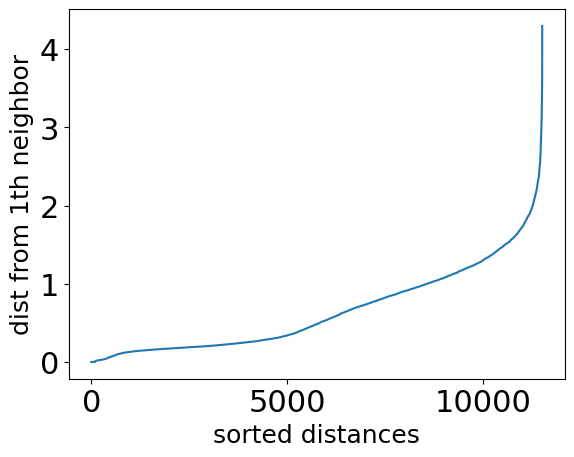

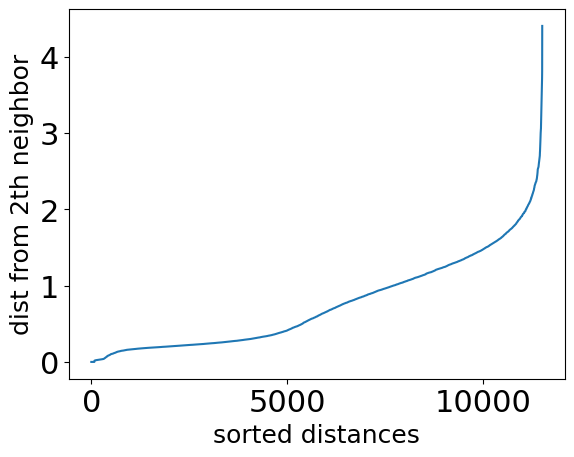

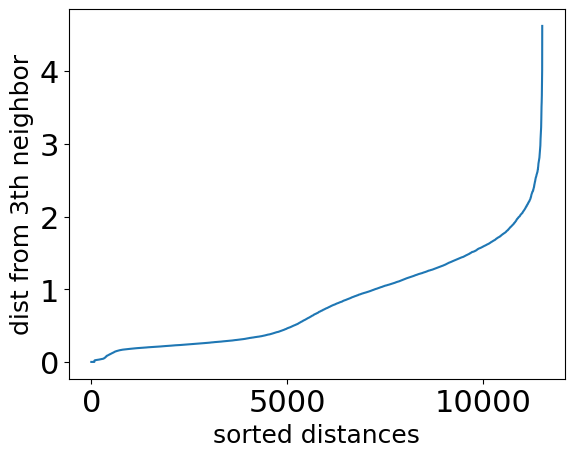

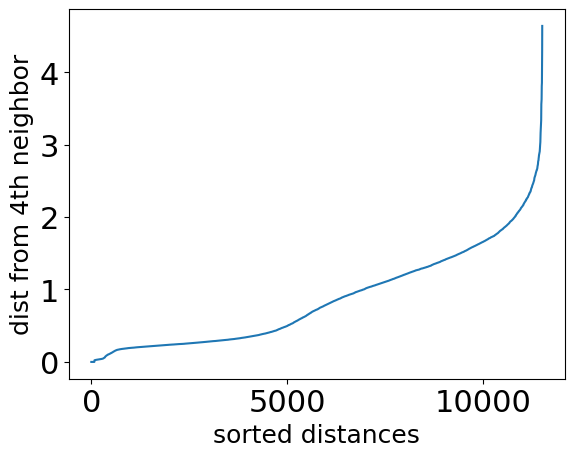

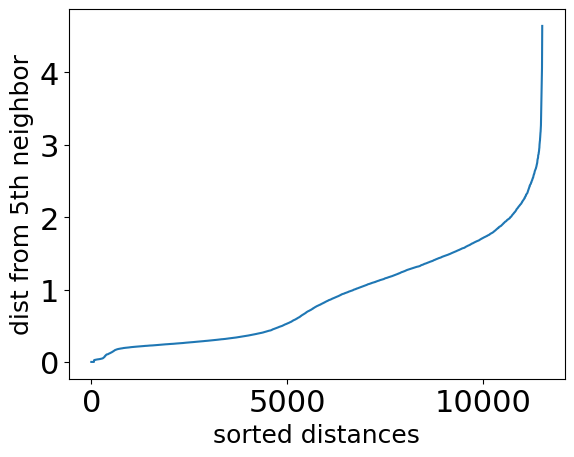

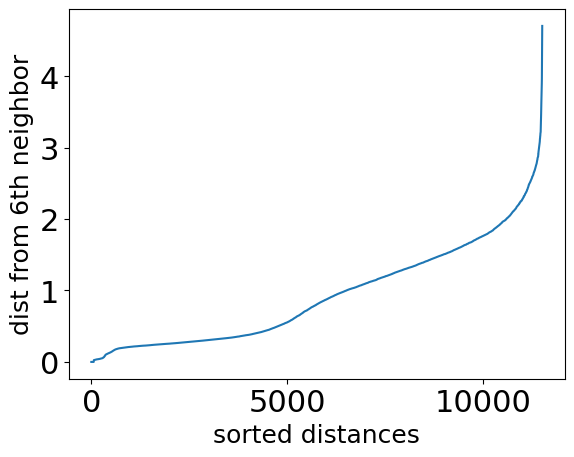

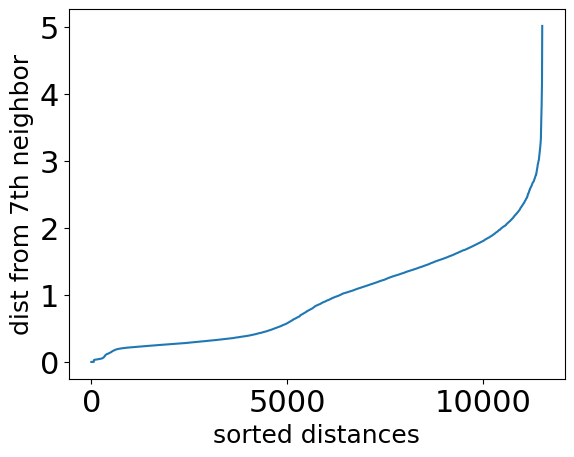

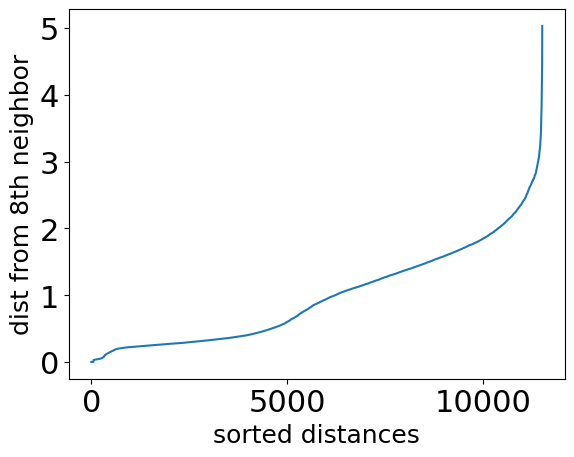

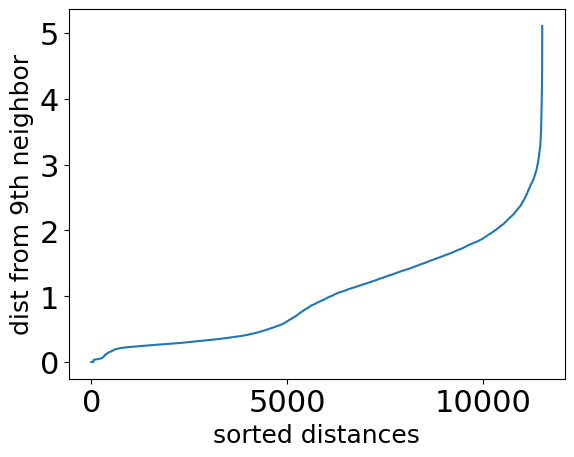

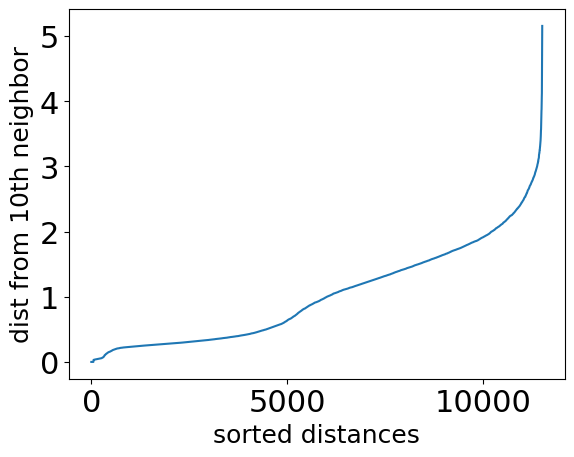

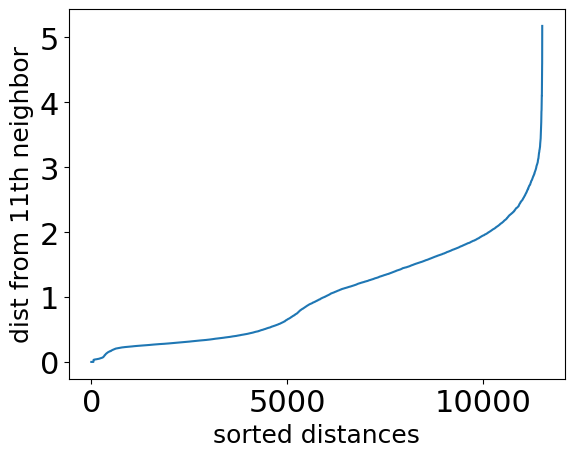

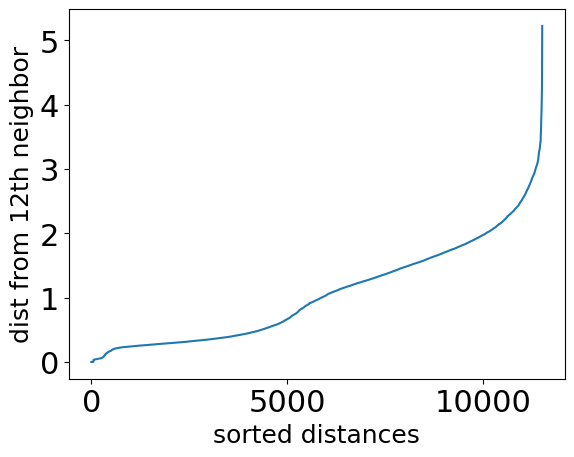

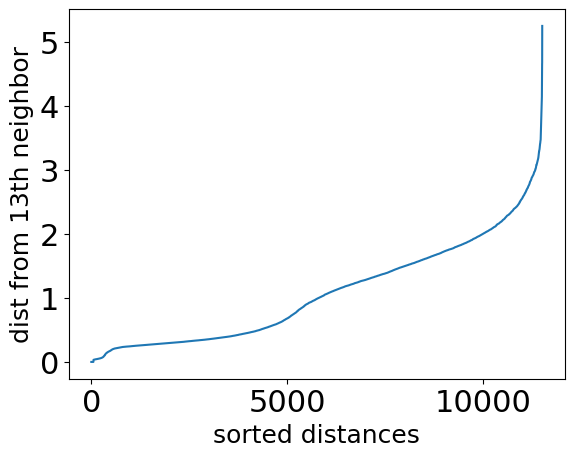

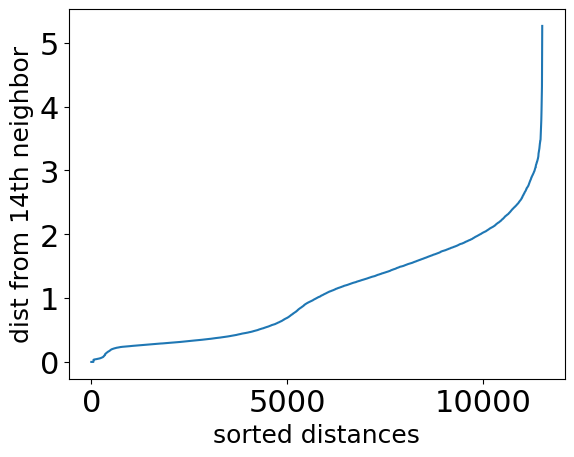

In [11]:
for k in range (1, 15):
    kth_distances = list()
    for d in dist:
        index_kth_distance = np.argsort(d)[k]
        kth_distances.append(d[index_kth_distance])
    plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
    plt.ylabel('dist from %sth neighbor' % k, fontsize=18)
    plt.xlabel('sorted distances', fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=22)
    #plt.axhline(y=1.7)
    plt.show()

For each curve select the distances that optimize the ELBO

In [12]:
dbscan = []
counter = 0
# choose best distance according to the plots,
# taking out the distance that represent the point just before the exponential increasing of the curve
# best_distance = [1.3, 1.45, 1.5, 1.55, 1.6, 1.75, 1.8, 1.9, 2, 2.1, 2.2, 2.3, 2.4]

best_distance = [1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 2.1, 2.2, 2.3, 2.4]

for i in best_distance:
    dbscan.append(DBSCAN(eps=i, min_samples=counter + 2).fit(X))
    counter += 1

In [13]:
# compute and print the number of clusters found by the DBSCAN runs
counter_i = 0
for i in dbscan:
    counter_j = 0
    print("DBSCAN with " + str(counter_i + 2) + " neighbors:\n", "Noise Points: " + str(np.unique(i.labels_, return_counts=True)[1][0]) + "\n", "Points in the other clusters:")
    for j in np.unique(i.labels_, return_counts=True)[1]:
        if counter_j != 0:
            print("Cluster " +  str(counter_j) + ": " + str(j) + "   ", end = '')
            if counter_j % 5 == 0:
                print("")
        counter_j += 1
    print("\n")
    counter_i += 1

DBSCAN with 2 neighbors:
 Noise Points: 1919
 Points in the other clusters:
Cluster 1: 7228   Cluster 2: 142   Cluster 3: 56   Cluster 4: 2   Cluster 5: 339   
Cluster 6: 119   Cluster 7: 28   Cluster 8: 5   Cluster 9: 329   Cluster 10: 9   
Cluster 11: 2   Cluster 12: 2   Cluster 13: 79   Cluster 14: 3   Cluster 15: 6   
Cluster 16: 169   Cluster 17: 4   Cluster 18: 210   Cluster 19: 4   Cluster 20: 2   
Cluster 21: 4   Cluster 22: 13   Cluster 23: 4   Cluster 24: 2   Cluster 25: 2   
Cluster 26: 2   Cluster 27: 2   Cluster 28: 2   Cluster 29: 3   Cluster 30: 2   
Cluster 31: 6   Cluster 32: 15   Cluster 33: 108   Cluster 34: 16   Cluster 35: 6   
Cluster 36: 3   Cluster 37: 5   Cluster 38: 9   Cluster 39: 3   Cluster 40: 6   
Cluster 41: 7   Cluster 42: 3   Cluster 43: 4   Cluster 44: 3   Cluster 45: 2   
Cluster 46: 2   Cluster 47: 4   Cluster 48: 2   Cluster 49: 2   Cluster 50: 3   
Cluster 51: 2   Cluster 52: 4   Cluster 53: 2   Cluster 54: 2   Cluster 55: 4   
Cluster 56: 3   Clu

In [14]:
# compute and print the silouette and the Separation of the DBSCAN runs
for num_neig, dbscan_sample in enumerate(dbscan, 2):
    print(f'Silhouette with {num_neig} neigs : {silhouette_score(X, dbscan_sample.labels_)}')
    print(f'Separation with {num_neig} neigs : {metrics.davies_bouldin_score(X, dbscan_sample.labels_)}')
    print()

Silhouette with 2 neigs : -0.2374223317791838
Separation with 2 neigs : 1.330675756300007

Silhouette with 3 neigs : -0.19202325362405248
Separation with 3 neigs : 1.3351616719162154

Silhouette with 4 neigs : -0.0991023157245547
Separation with 4 neigs : 1.3280753548126145

Silhouette with 5 neigs : -0.03279811346241698
Separation with 5 neigs : 1.3707347501628009

Silhouette with 6 neigs : -0.037437457378084196
Separation with 6 neigs : 1.4104563844300906

Silhouette with 7 neigs : -0.024638500518755754
Separation with 7 neigs : 1.4815929504412895

Silhouette with 8 neigs : -0.005155432819750603
Separation with 8 neigs : 1.6536794741653427

Silhouette with 9 neigs : 0.05183641277967525
Separation with 9 neigs : 1.987170653932169

Silhouette with 10 neigs : 0.1023114562304859
Separation with 10 neigs : 2.151238289137768

Silhouette with 11 neigs : 0.22529833311203956
Separation with 11 neigs : 3.5640733251466754

Silhouette with 12 neigs : 0.22993941624018385
Separation with 12 neigs 

Select out the best combination of parameters, in this case we have choose the method that produce only two clusters, the one with 11 neighbors and distance as 2.1, since the other runs produce cluster too small, in our opinion this is a good tradeoff in Silouette and Separation Score.

In [15]:
result = dbscan[-4]
num_clusters = 2 # even the noise cluster

In [16]:
#aggiungo ogni elemento nel proprio cluster di appartenenza, eliminando i punti di noise
clusters = []
pos = 0
for i in range (num_clusters):
    clusters.append(list())
for i in (result.labels_):
    clusters[i].append(X[pos])
    pos = pos + 1

In [17]:
#computes centroids for each cluster
centroids = list()
for cluster in clusters:
    x_ = np.zeros(X.shape[1])
    for i in cluster:
        x_ += i
    x_ /= len(cluster)    
    
    centroids.append(x_)

Plot The number of samples in each cluster

In [18]:
hist, bins = np.histogram(result.labels_,
                          bins=range(-1, len(set(result.labels_))))
dict(zip(bins, hist))

{-1: 437, 0: 11071}

We can notice that the DBSCAN returns only two clusters in which one is very big and the other has few samples, even the noise cluster has very low samples. This is not so good, but the choosen parameters configuration is one of the best found within the tryed ones. 

In [19]:
dbscan_unique_labels = np.concatenate([np.unique(result.labels_)[1:], [-1]])

### Plot Cluster Results

Plot the centroids in a tabular way, to have a summary of the clusters

In [20]:
pd.DataFrame(centroids, columns=df_num_not_skewed.columns, index=dbscan_unique_labels)

log_statuses_count  avg_length  log_avg_special_chars  log_urls_ratio  \
 0           -0.007033   -0.018654              -0.011037       -0.047046   
-1            0.178187    0.472577               0.279621        1.191872   

    log_mentions_ratio  log_hashtags_ratio  log_reply_count_mean  \
 0           -0.028081           -0.023845             -0.010428   
-1            0.711395            0.604102              0.264188   

    log_reply_count_std  log_favorite_count_mean  log_favorite_count_std  \
 0            -0.009265                -0.026032               -0.031815   
-1             0.234720                 0.659486                0.806014   

    log_favorite_count_entropy  log_retweet_count_mean  log_retweet_count_std  \
 0                   -0.022469               -0.017861              -0.017065   
-1                    0.569244                0.452488               0.432327   

    log_retweet_count_entropy  
 0                  -0.016103  
-1                   0.407960

In [21]:
centers_not_skewed = scaler.inverse_transform(centroids)

In [22]:
pd.DataFrame(centers_not_skewed, columns=df_num_not_skewed.columns, index=dbscan_unique_labels)

log_statuses_count  avg_length  log_avg_special_chars  log_urls_ratio  \
 0            5.388908   66.862211               2.762127        0.027025   
-1            5.833023   73.127728               2.806537        0.087694   

    log_mentions_ratio  log_hashtags_ratio  log_reply_count_mean  \
 0            0.261967            0.091802              0.001855   
-1            0.438260            0.142137              0.003959   

    log_reply_count_std  log_favorite_count_mean  log_favorite_count_std  \
 0             0.021083                 0.073962                0.268542   
-1             0.036115                 0.137466                0.478486   

    log_favorite_count_entropy  log_retweet_count_mean  log_retweet_count_std  \
 0                    0.286708                1.904022               2.825825   
-1                    0.434590                3.028546               4.198200   

    log_retweet_count_entropy  
 0                   0.517144  
-1                   0.747388

In [23]:
centers = reverse_log_skewed(centers_not_skewed, df_num, skewed_features)

In [24]:
pd.DataFrame(centers, columns=df_num.columns, index=dbscan_unique_labels)

statuses_count  avg_length  avg_special_chars  urls_ratio  mentions_ratio  \
 0      217.964037   66.862211          14.833481    0.027394        0.299484   
-1      340.389042   73.127728          15.552498    0.091654        0.550008   

    hashtags_ratio  reply_count_mean  reply_count_std  favorite_count_mean  \
 0        0.096147          0.001857         0.021307             0.076766   
-1        0.152735          0.003967         0.036775             0.147362   

    favorite_count_std  favorite_count_entropy  retweet_count_mean  \
 0            0.308056                0.332035            5.712840   
-1            0.613630                0.544329           19.667167   

    retweet_count_std  retweet_count_entropy  
 0          15.874861               0.677230  
-1          65.566411               1.111478

Plot the centroids coordinates in parallel and radar coordinates, we can see that the different centroids have values of the features that vary in the magnitude between different clusters, so each cluster represent a kind of behaviour different with respect the others.

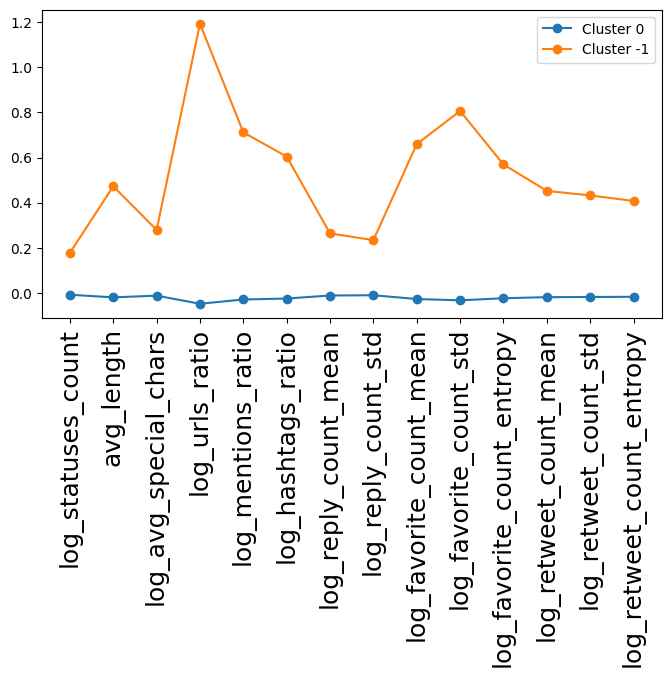

In [25]:
plt.figure(figsize=(8, 4))
for i in range(0, len(centroids)):
    plt.plot(centroids[i], marker='o', label='Cluster %s' % dbscan_unique_labels[i])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(range(0, len(df_num_not_skewed.columns)), df_num_not_skewed.columns, fontsize=18, rotation=90)
plt.legend(fontsize=10)
plt.savefig(f"../images/clustering/dbscan_parallel.png")
plt.show()

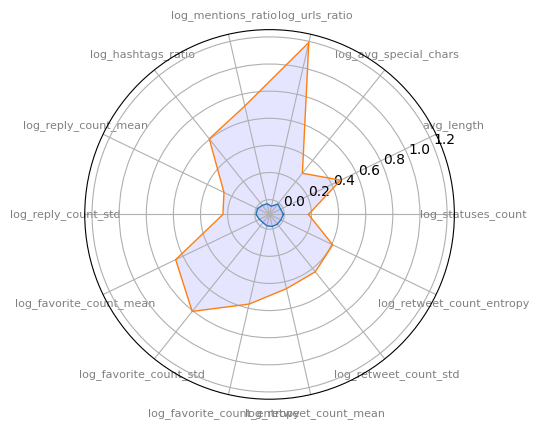

In [26]:
plot_radar_clusters(df_num_not_skewed, centroids, "dbscan")

#### Distribution of CategoricalFeatures per Cluster

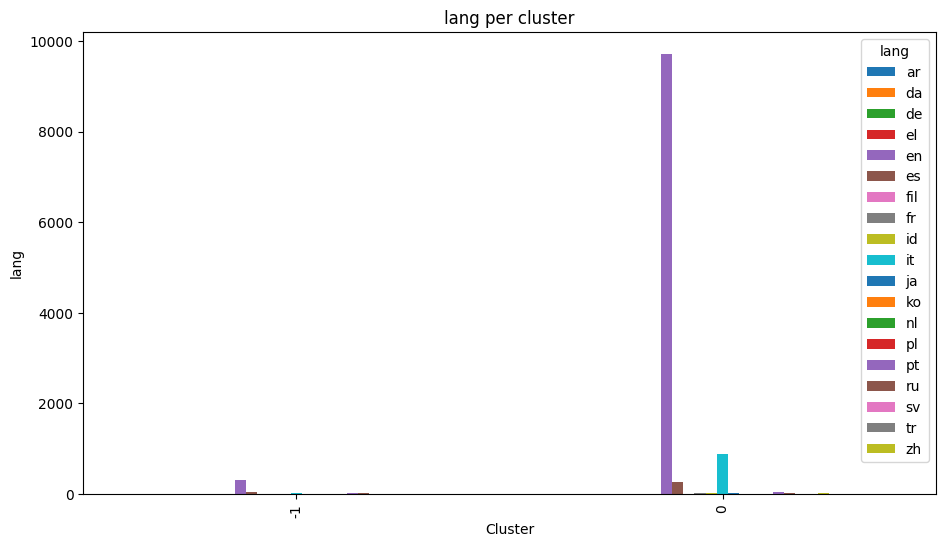

In [27]:
categorical_hist_clusters(df_cat, result.labels_, "lang", "dbscan")

Plot the distribution of bot and non-bot user per cluster, we can see that each cluster have, more or less, the same number of the two classes, this is radically different w.r.t. the other clustering methods.

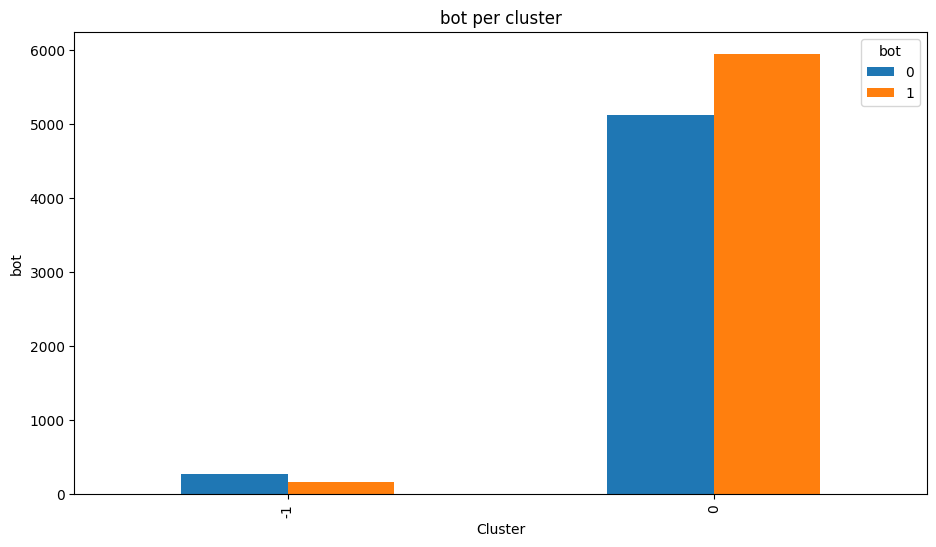

In [28]:
categorical_hist_clusters(df_cat, result.labels_, "bot", "dbscan")

compute the entropy of the feature bot in each cluster

In [29]:
entropy_clusters(df_cat, result.labels_, "bot")

labels
-1    0.665107
 0    0.690355
Name: bot, dtype: float64

Plot of the **created_at** feature (grouped by year) of the user in each cluster

0
11071


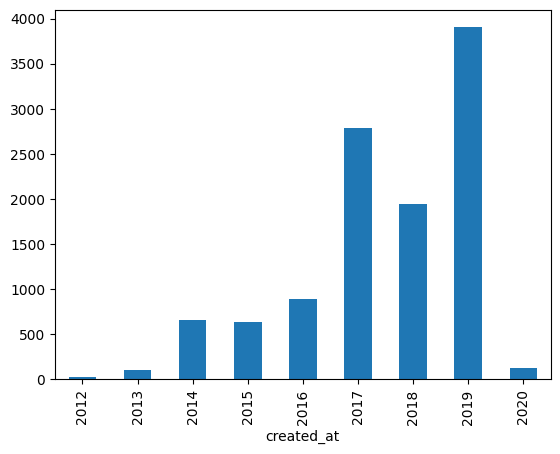

-1
437


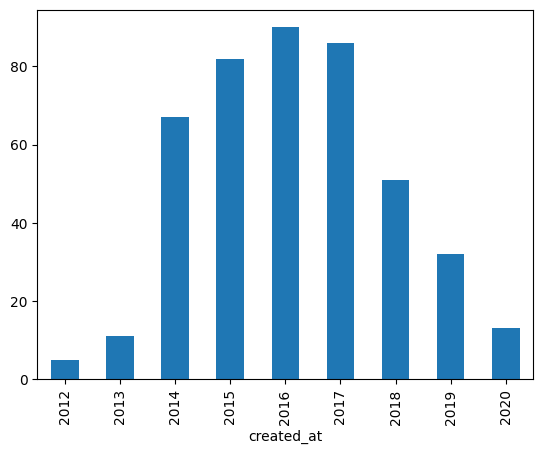

In [30]:
for i in dbscan_unique_labels:
    i_samples = result.labels_==i
    print(i)
    print(np.sum(i_samples))
    df[i_samples].name.groupby(pd.to_datetime(df.loc[i_samples, 'created_at'], format='%Y-%m-%d %H:%M:%S', errors='raise').dt.year).count().plot(kind="bar")
    plt.show()

#### Distribution of Numerical Features per Cluster

We will plot the distribution of the variables in the original space, plotting the boxplots and histogram of each numerical feature for each discovered cluster.

Cluster: 0


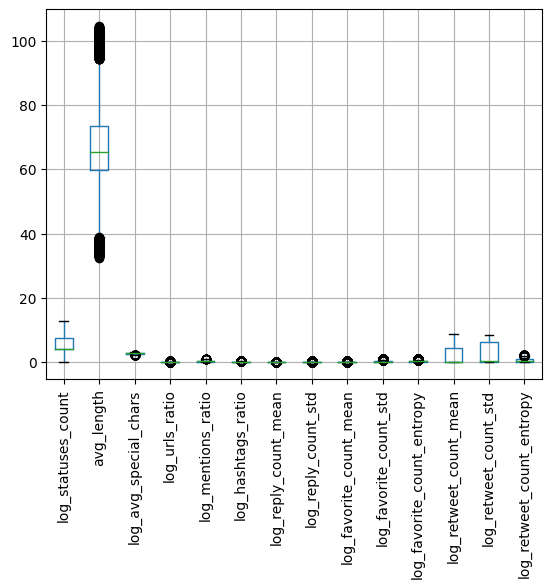

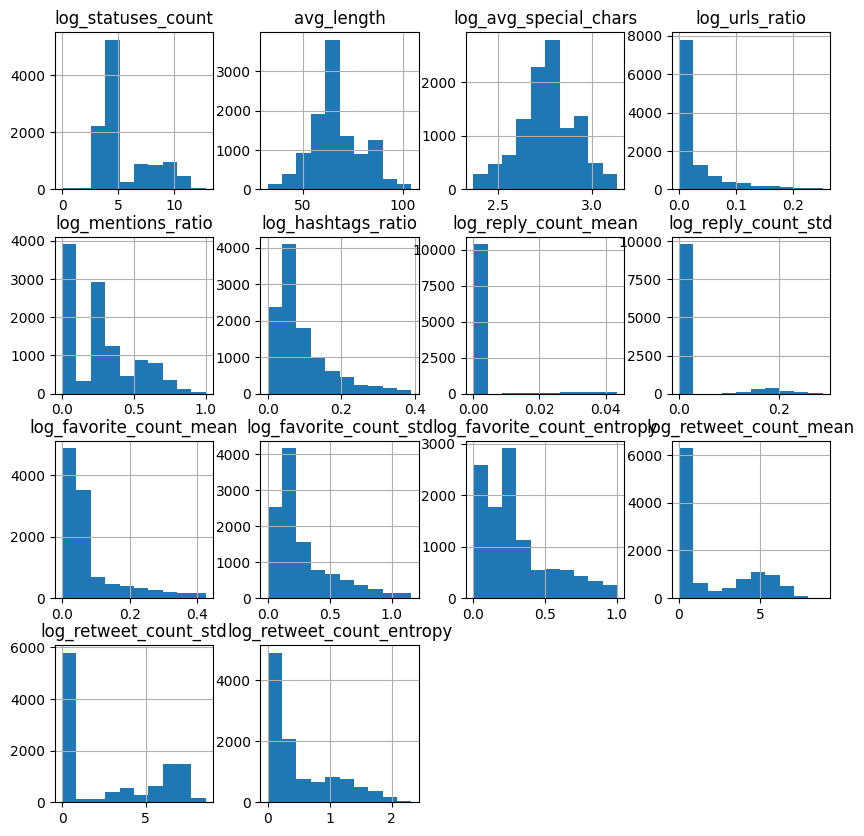

Cluster: -1


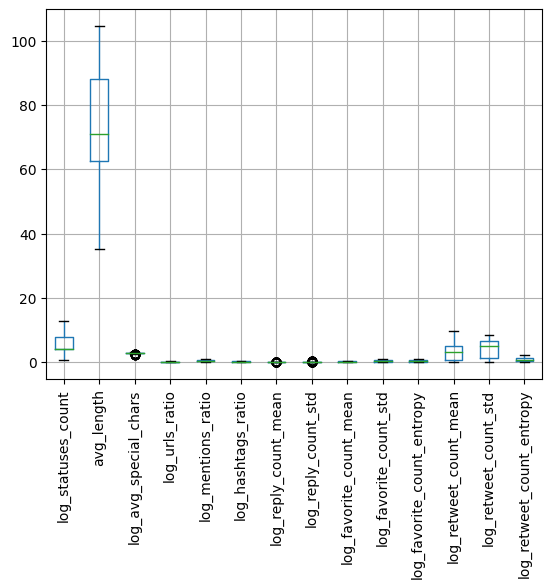

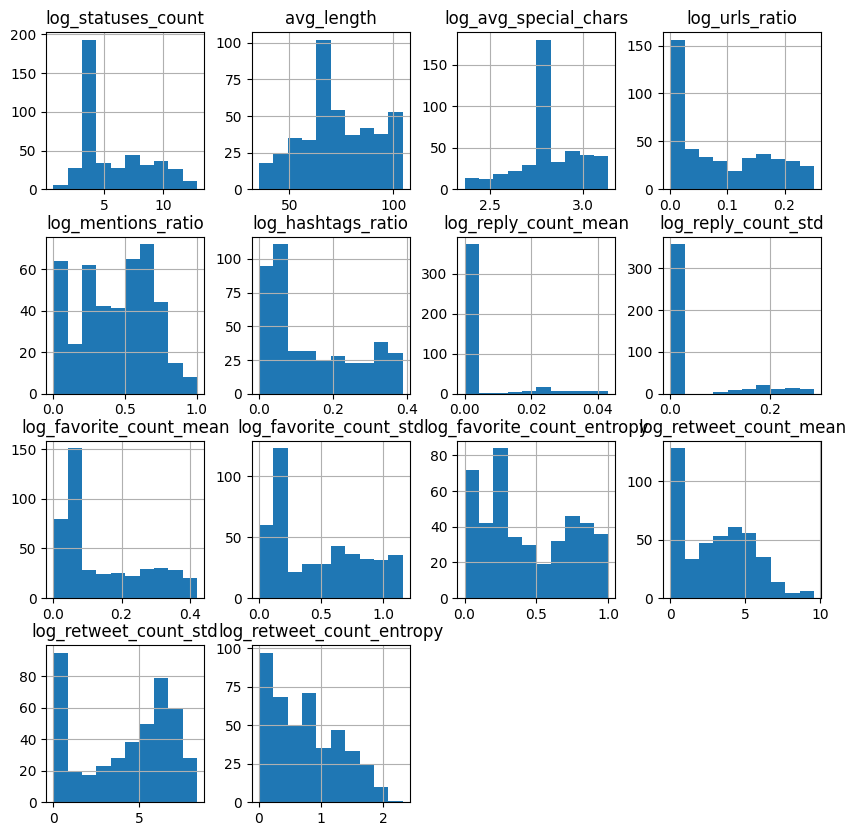

In [31]:
for i in dbscan_unique_labels:
    print(f"Cluster: {i}")
    i_samples = result.labels_==i
    df_num_not_skewed[i_samples].boxplot()
    plt.xticks(rotation=90)
    df_num_not_skewed[i_samples].hist(figsize=(10,10))
    plt.xticks(rotation=90)
    plt.show()

### Report statistics of each cluster

First print out the std and mean of all the dataset

In [32]:
df_num_not_skewed.describe().loc[["std", "mean"]]

log_statuses_count  avg_length  log_avg_special_chars  log_urls_ratio  \
std             2.397867   12.755296               0.152799        0.048971   
mean            5.405772   67.100135               2.763813        0.029329   

      log_mentions_ratio  log_hashtags_ratio  log_reply_count_mean  \
std             0.238413            0.080162              0.007662   
mean            0.268662            0.093713              0.001935   

      log_reply_count_std  log_favorite_count_mean  log_favorite_count_std  \
std              0.061613                 0.092640                0.250592   
mean             0.021654                 0.076374                0.276514   

      log_favorite_count_entropy  log_retweet_count_mean  \
std                     0.249932                2.390933   
mean                    0.292324                1.946724   

      log_retweet_count_std  log_retweet_count_entropy  
std                3.053982                   0.542972  
mean               2.877939                   0.525887

Then print out the std and mean of data grouped in clusters

In [33]:
for i in dbscan_unique_labels:
    print()
    print(f"cluster {i}:")
    i_samples = result.labels_==i
    print(df_num_not_skewed[i_samples].describe().loc[["std", "mean"]])
    print()
    print()


cluster 0:
      log_statuses_count  avg_length  log_avg_special_chars  log_urls_ratio  \
std             2.381214   12.457139               0.151780        0.045738   
mean            5.388908   66.862211               2.762127        0.027025   

      log_mentions_ratio  log_hashtags_ratio  log_reply_count_mean  \
std             0.235302            0.077561              0.007539   
mean            0.261967            0.091802              0.001855   

      log_reply_count_std  log_favorite_count_mean  log_favorite_count_std  \
std              0.060718                 0.090059                0.242448   
mean             0.021083                 0.073962                0.268542   

      log_favorite_count_entropy  log_retweet_count_mean  \
std                     0.245558                2.382722   
mean                    0.286708                1.904022   

      log_retweet_count_std  log_retweet_count_entropy  
std                3.055831                   0.540697  
mean     

### Scatter plots

Plotting the scatter plot of each pair of numerical features, coloring out the points with respect the cluster number of each sample

log_statuses_count - avg_length


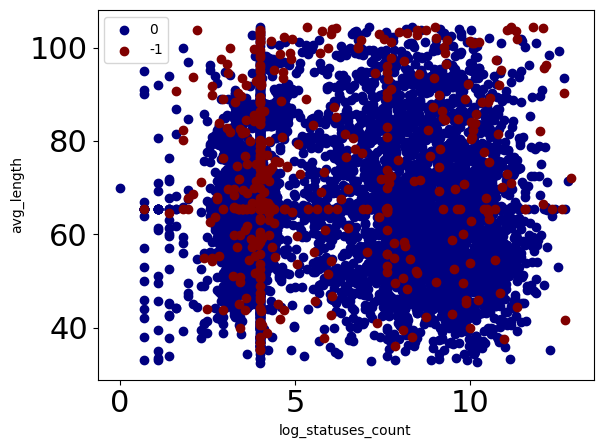

log_statuses_count - log_avg_special_chars


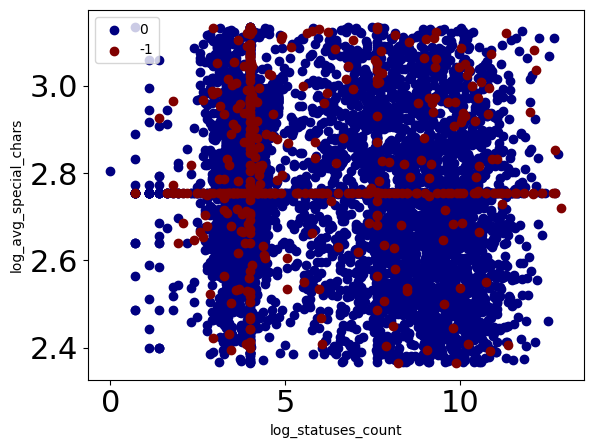

log_statuses_count - log_urls_ratio


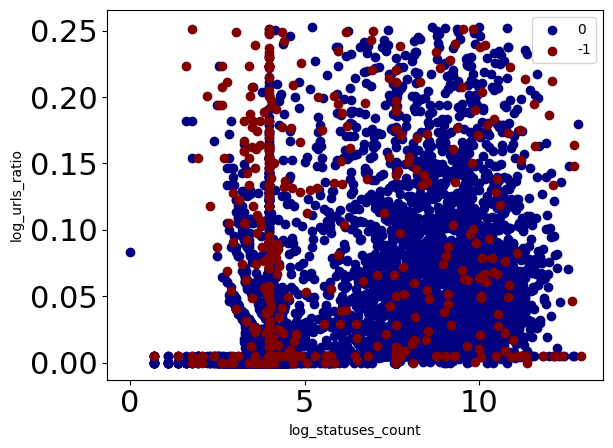

log_statuses_count - log_mentions_ratio


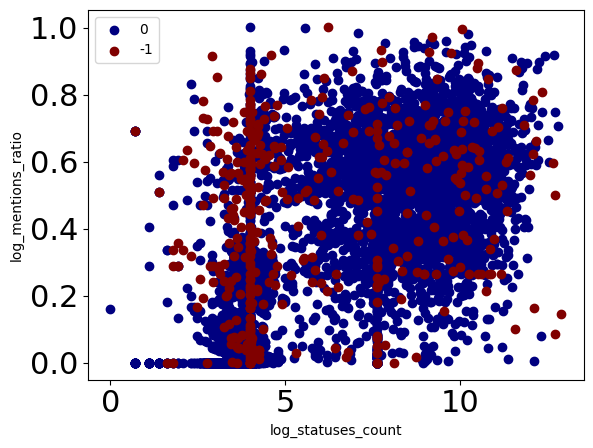

log_statuses_count - log_hashtags_ratio


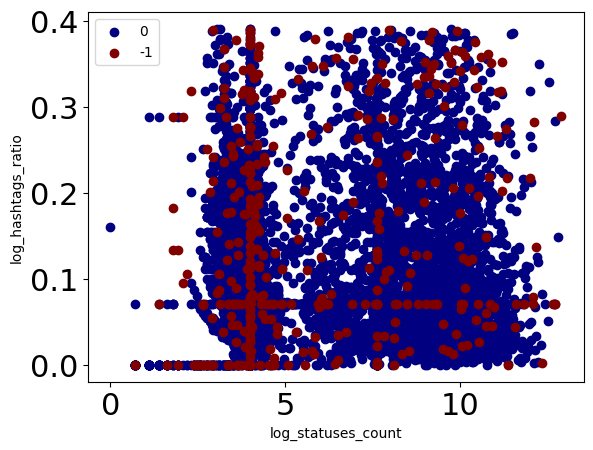

log_statuses_count - log_reply_count_mean


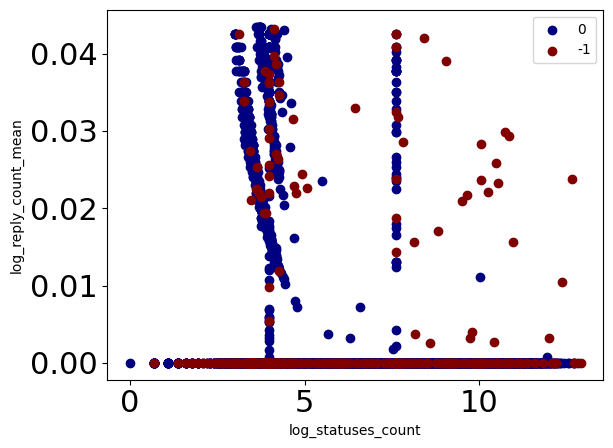

log_statuses_count - log_reply_count_std


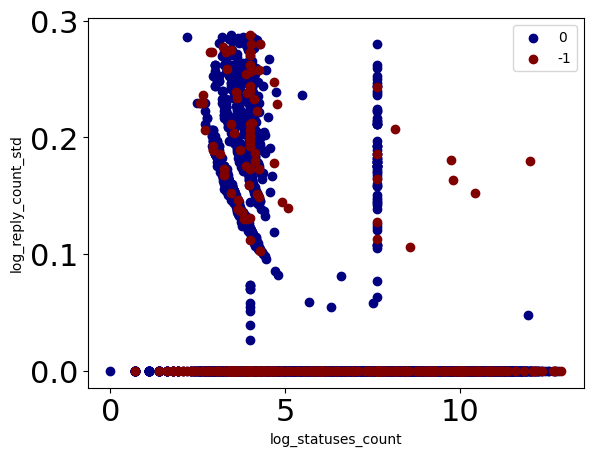

log_statuses_count - log_favorite_count_mean


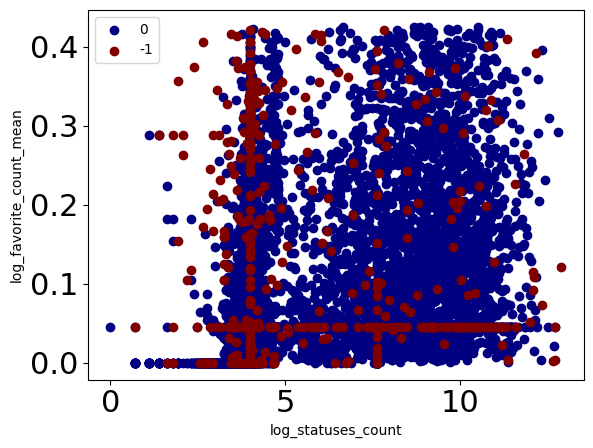

log_statuses_count - log_favorite_count_std


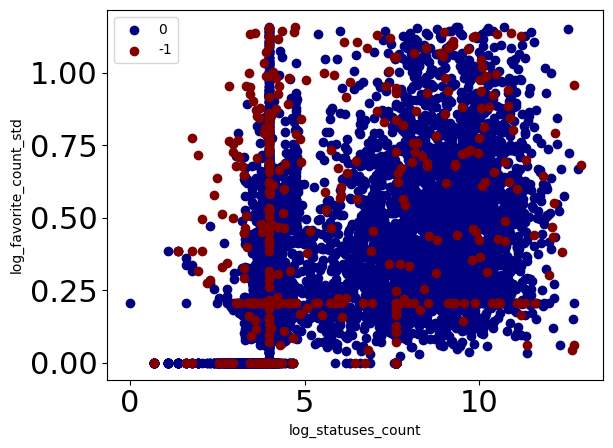

log_statuses_count - log_favorite_count_entropy


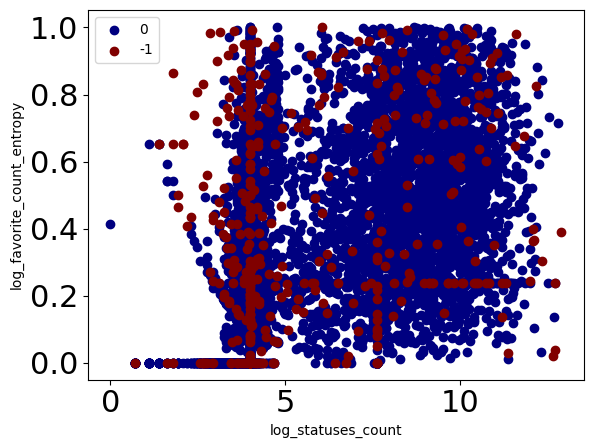

log_statuses_count - log_retweet_count_mean


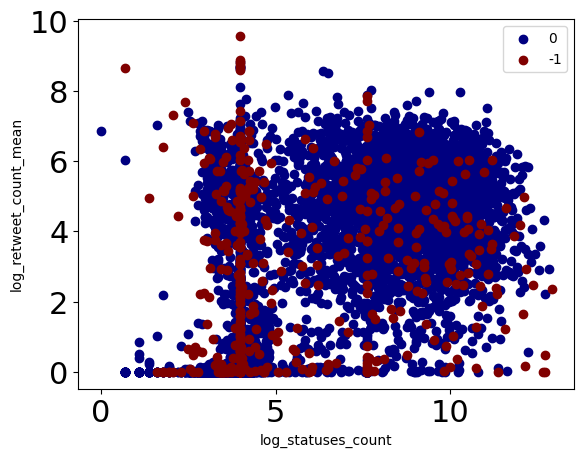

log_statuses_count - log_retweet_count_std


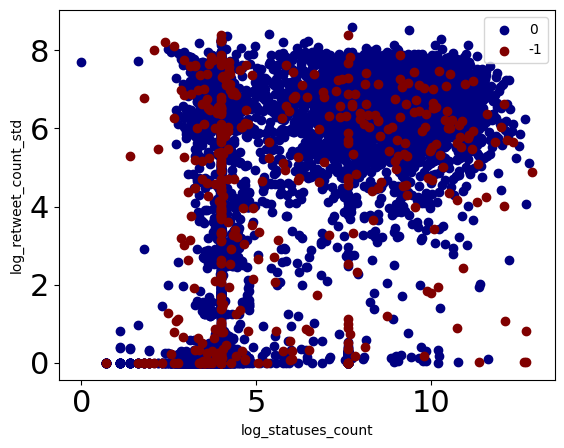

log_statuses_count - log_retweet_count_entropy


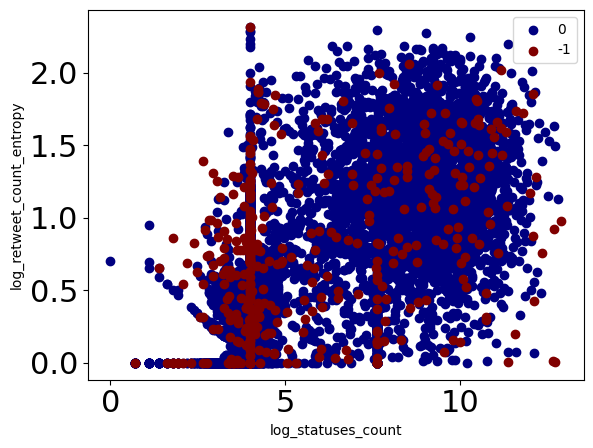

avg_length - log_avg_special_chars


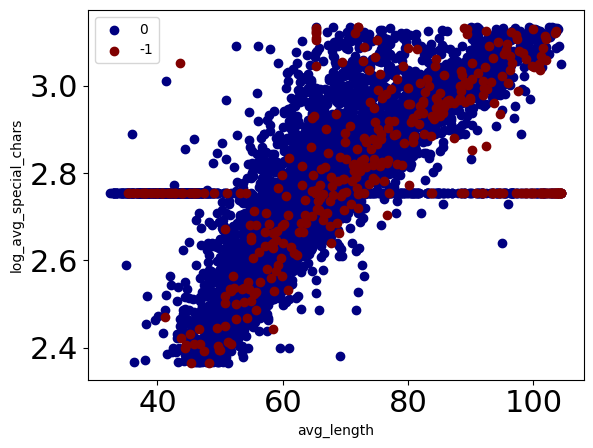

avg_length - log_urls_ratio


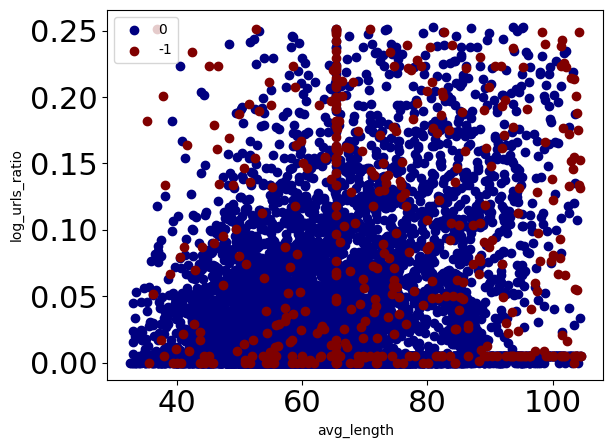

avg_length - log_mentions_ratio


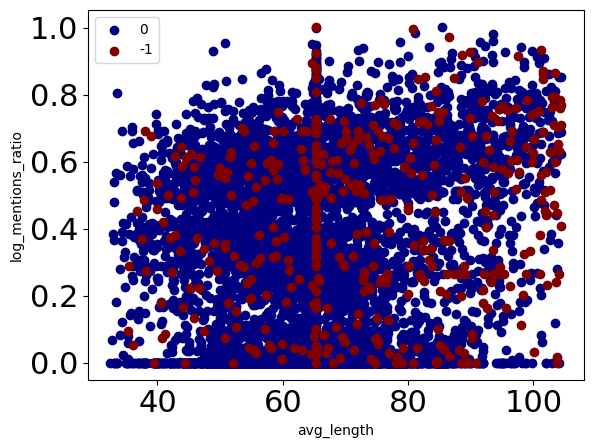

avg_length - log_hashtags_ratio


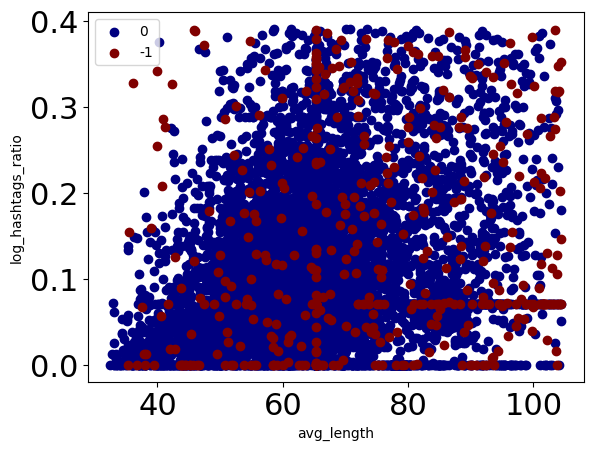

avg_length - log_reply_count_mean


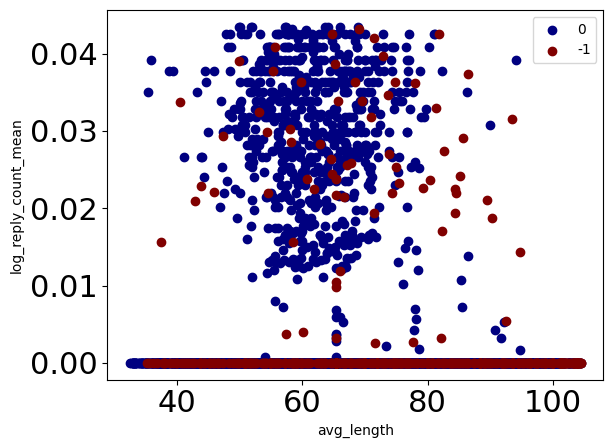

avg_length - log_reply_count_std


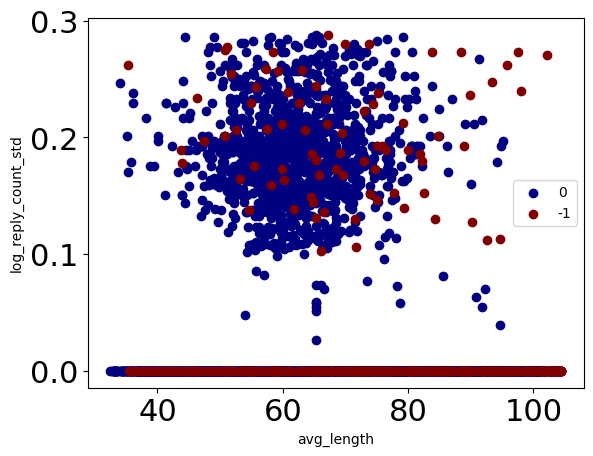

avg_length - log_favorite_count_mean


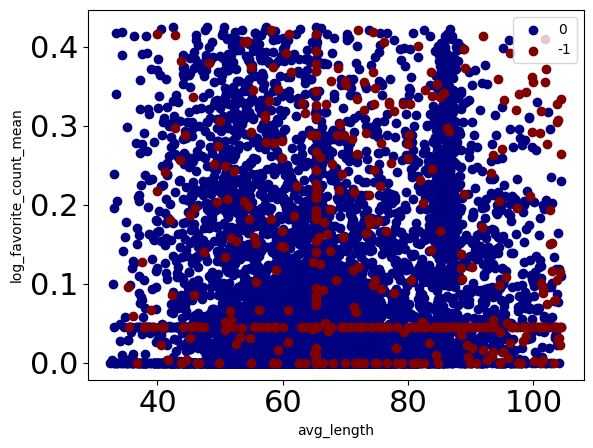

avg_length - log_favorite_count_std


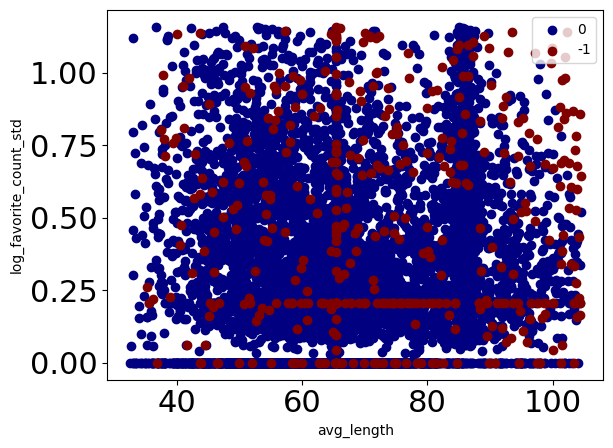

avg_length - log_favorite_count_entropy


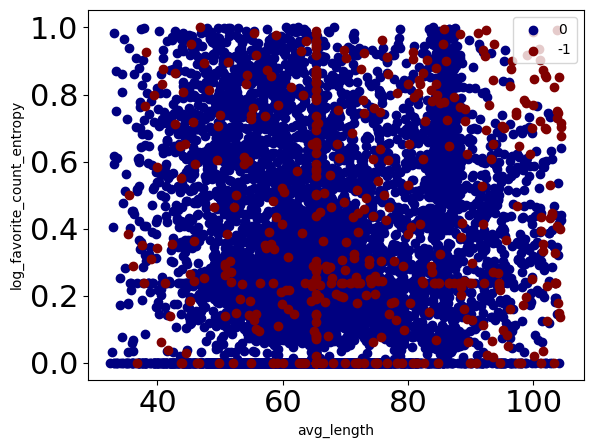

avg_length - log_retweet_count_mean


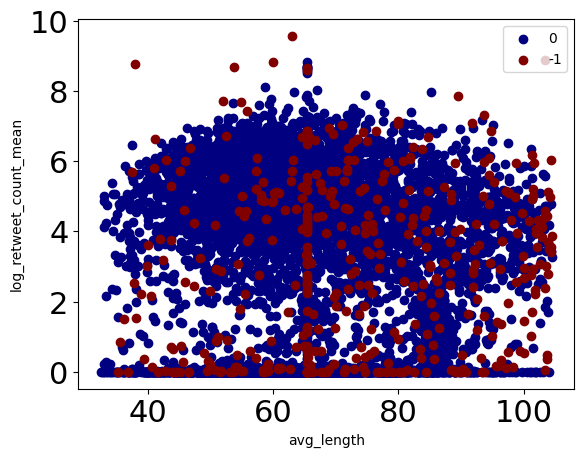

avg_length - log_retweet_count_std


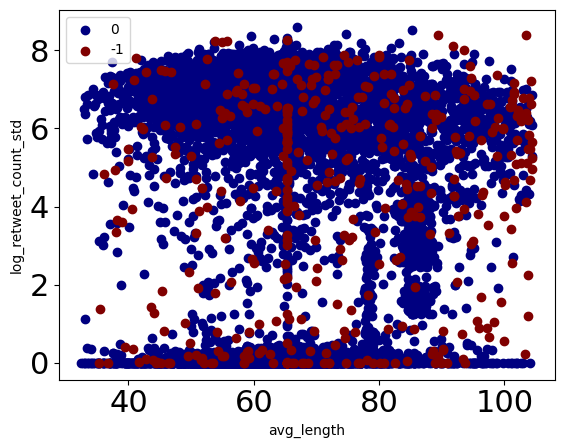

avg_length - log_retweet_count_entropy


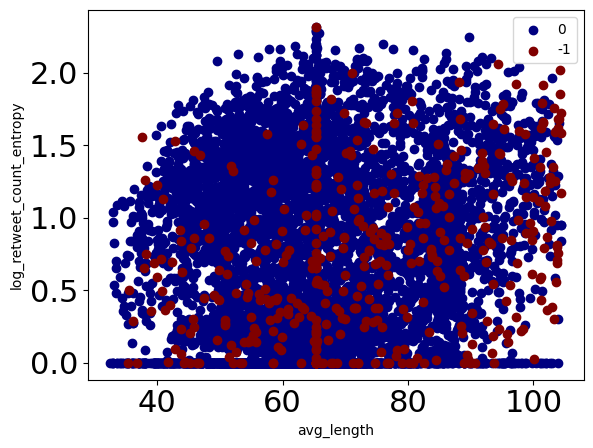

log_avg_special_chars - log_urls_ratio


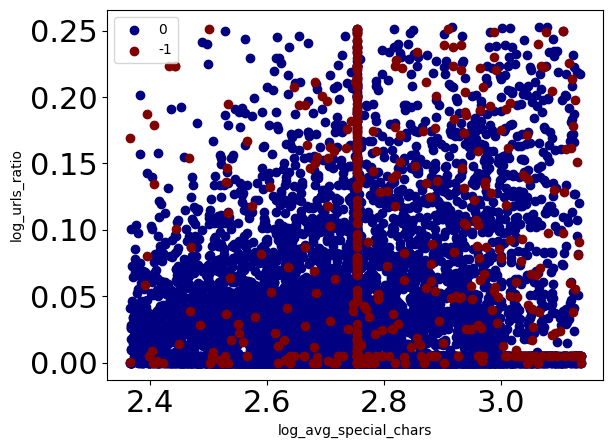

log_avg_special_chars - log_mentions_ratio


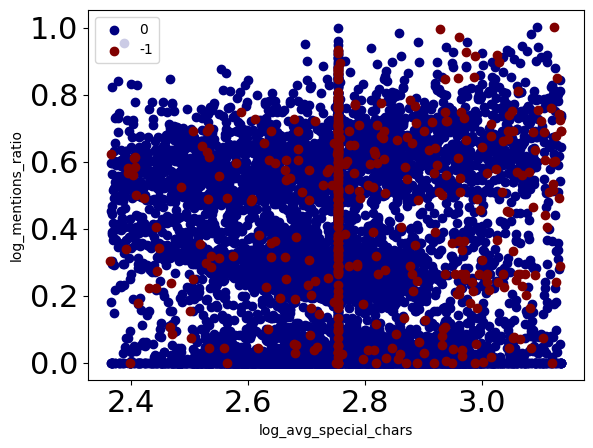

log_avg_special_chars - log_hashtags_ratio


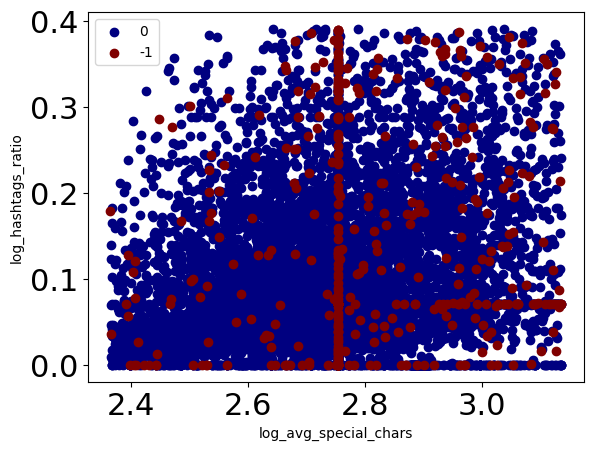

log_avg_special_chars - log_reply_count_mean


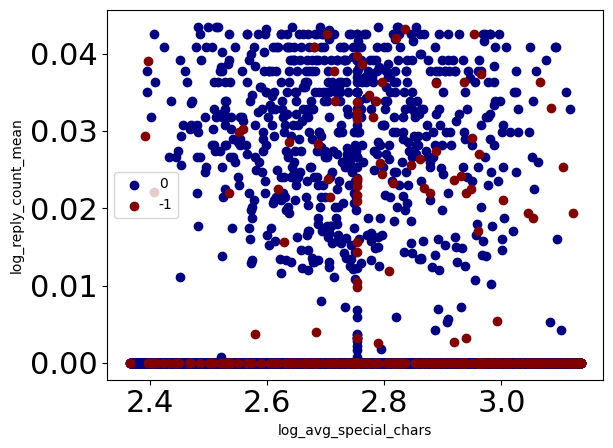

log_avg_special_chars - log_reply_count_std


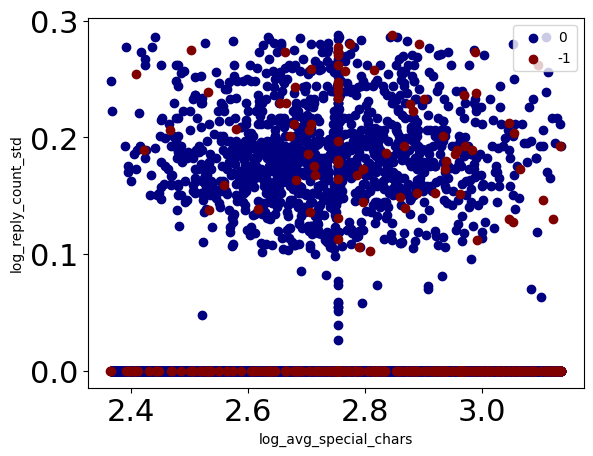

log_avg_special_chars - log_favorite_count_mean


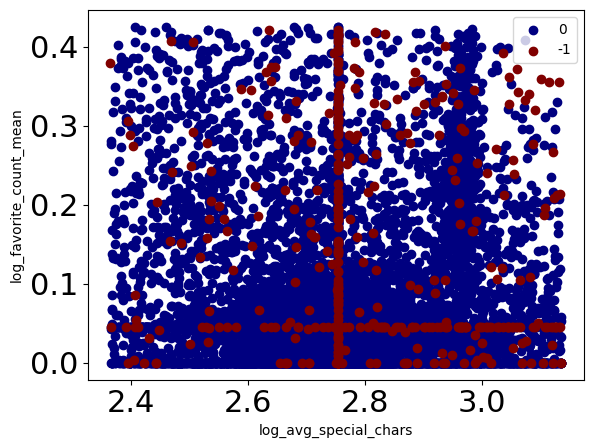

log_avg_special_chars - log_favorite_count_std


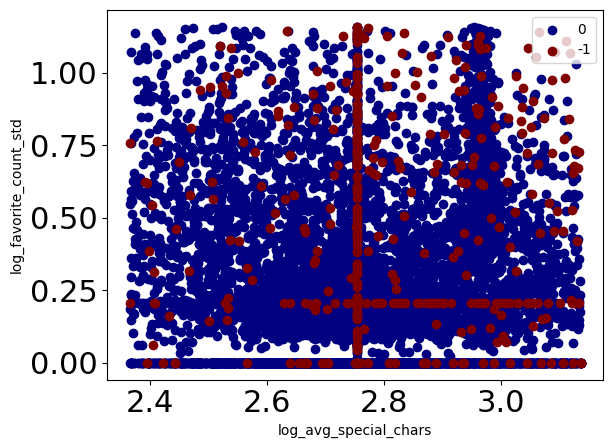

log_avg_special_chars - log_favorite_count_entropy


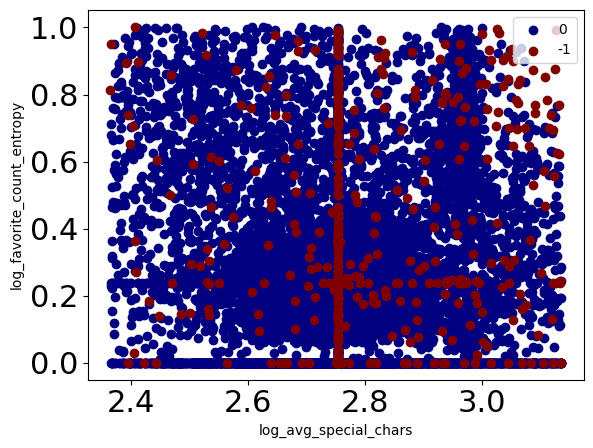

log_avg_special_chars - log_retweet_count_mean


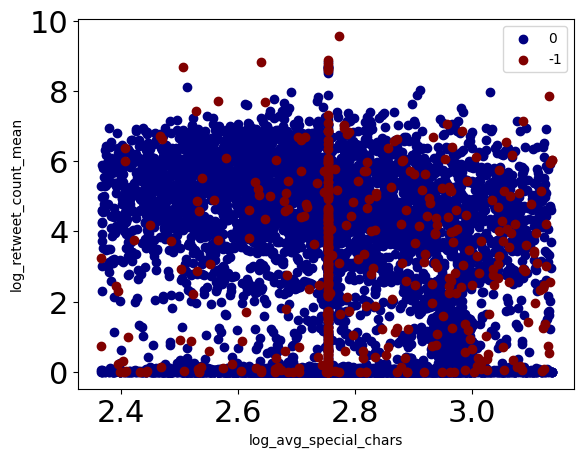

log_avg_special_chars - log_retweet_count_std


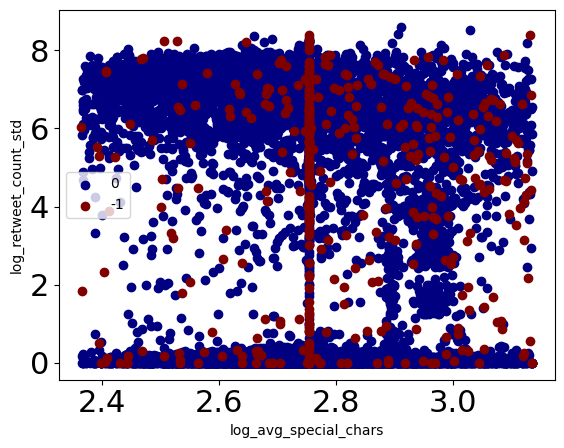

log_avg_special_chars - log_retweet_count_entropy


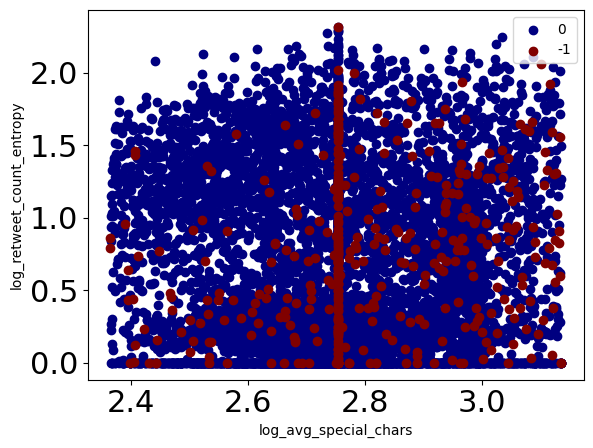

log_urls_ratio - log_mentions_ratio


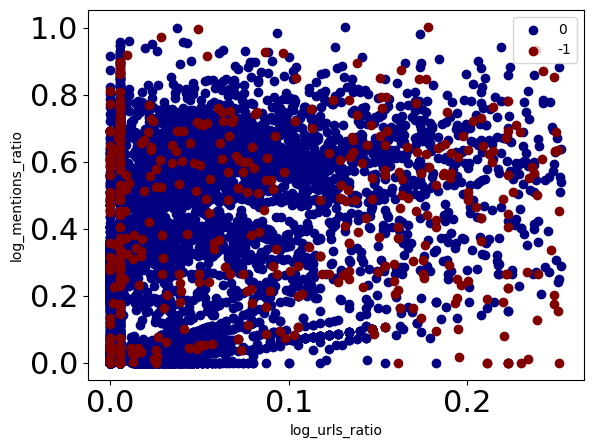

log_urls_ratio - log_hashtags_ratio


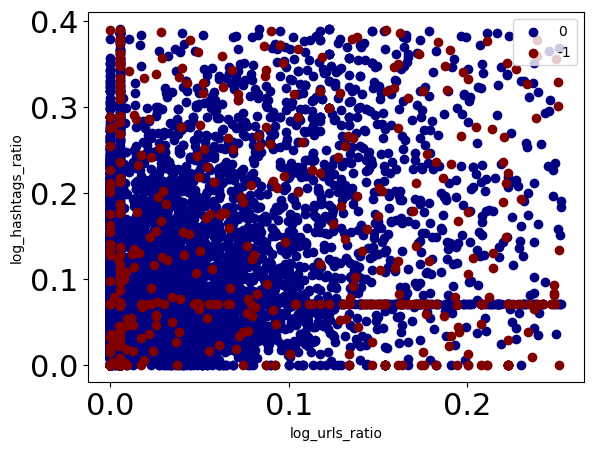

log_urls_ratio - log_reply_count_mean


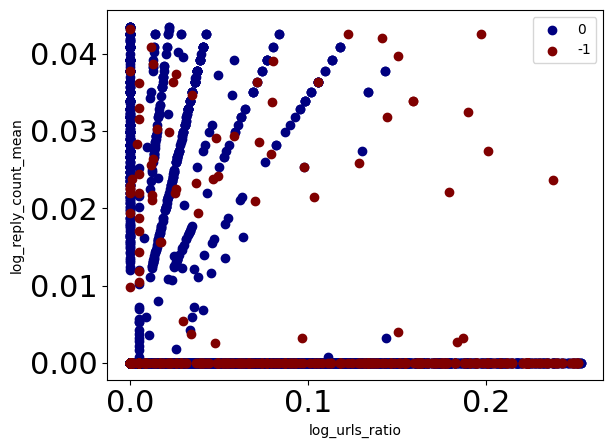

log_urls_ratio - log_reply_count_std


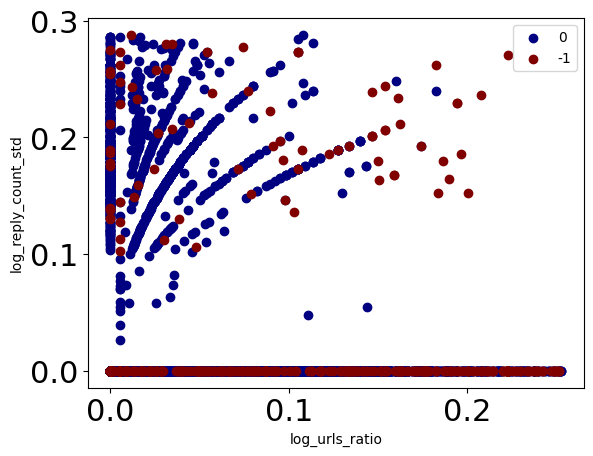

log_urls_ratio - log_favorite_count_mean


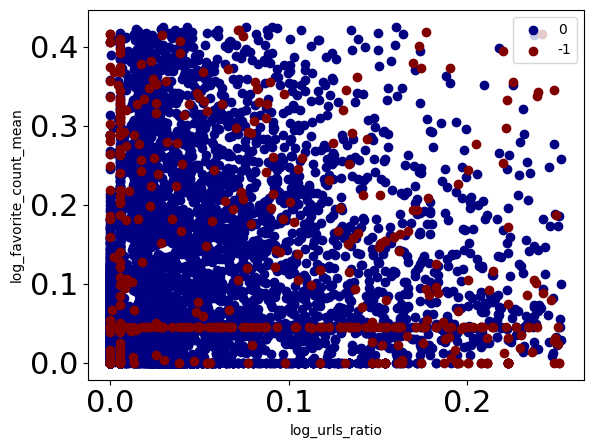

log_urls_ratio - log_favorite_count_std


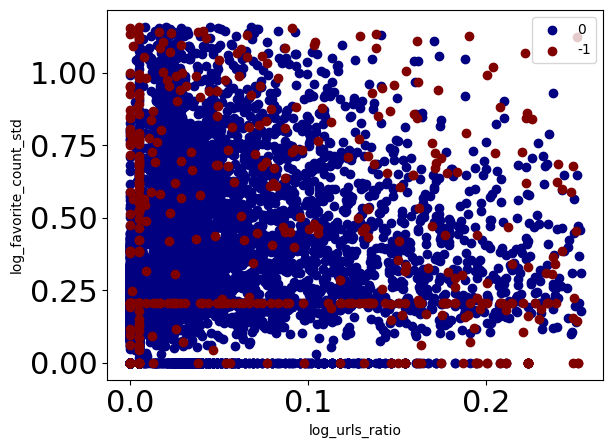

log_urls_ratio - log_favorite_count_entropy


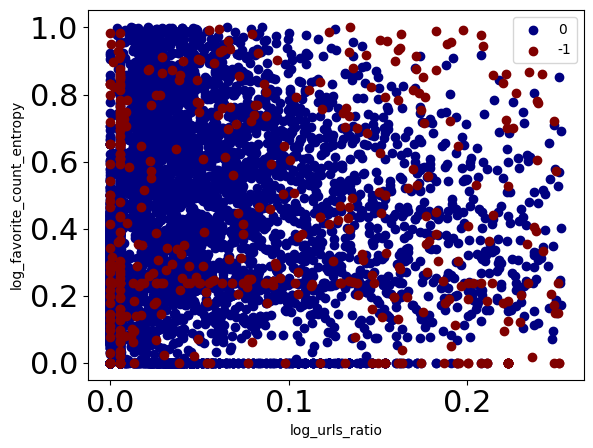

log_urls_ratio - log_retweet_count_mean


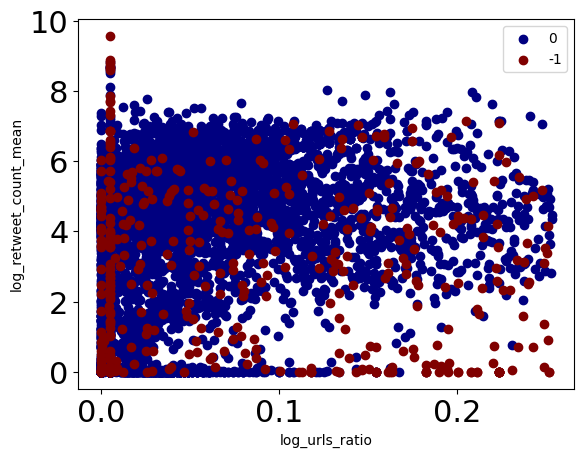

log_urls_ratio - log_retweet_count_std


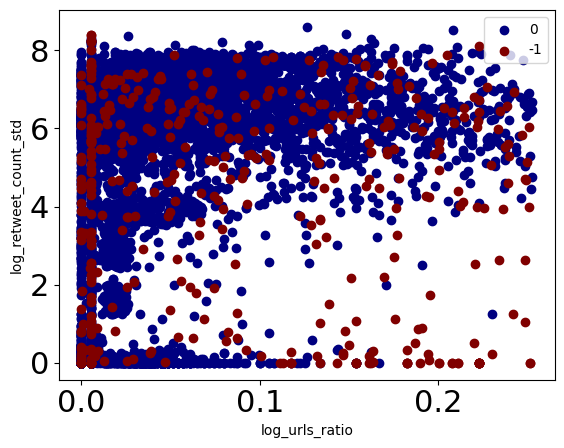

log_urls_ratio - log_retweet_count_entropy


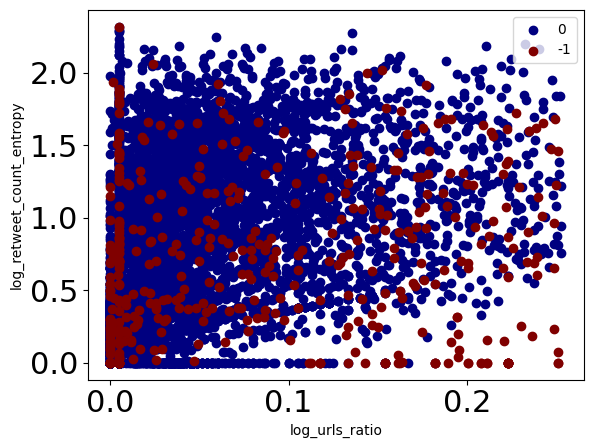

log_mentions_ratio - log_hashtags_ratio


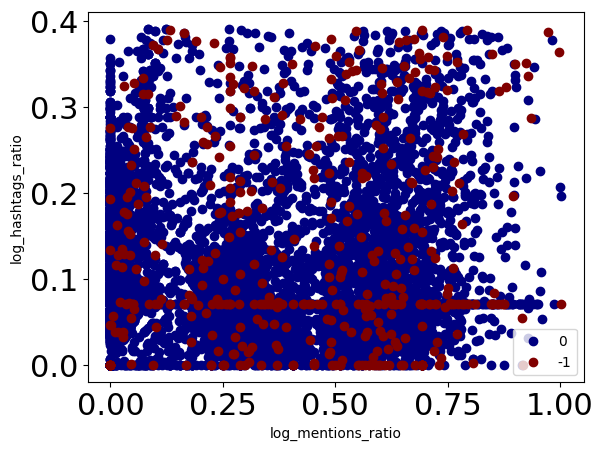

log_mentions_ratio - log_reply_count_mean


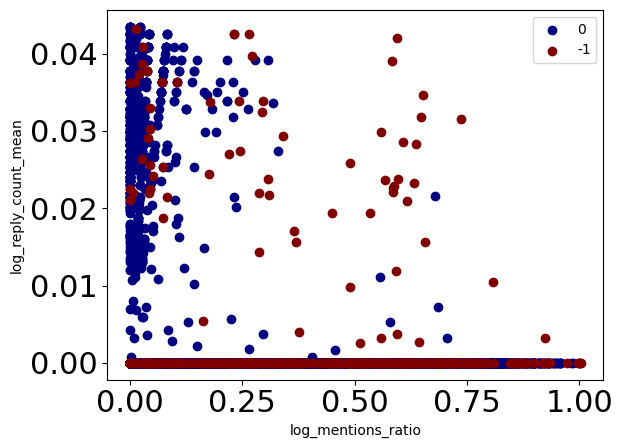

log_mentions_ratio - log_reply_count_std


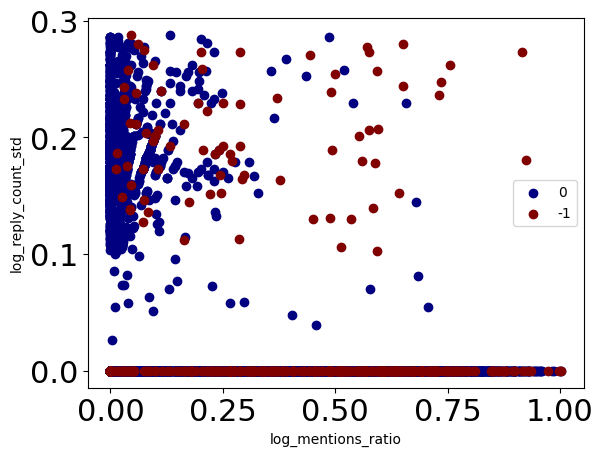

log_mentions_ratio - log_favorite_count_mean


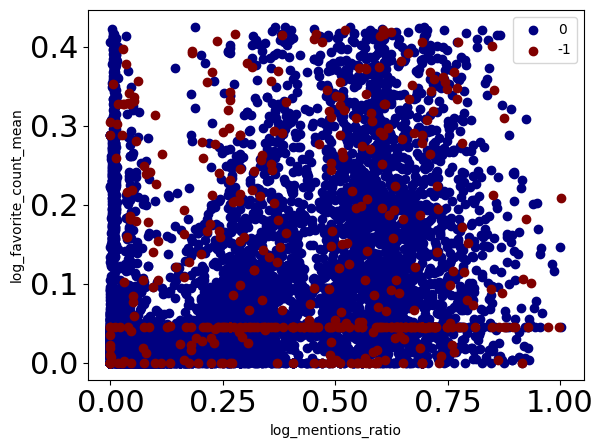

log_mentions_ratio - log_favorite_count_std


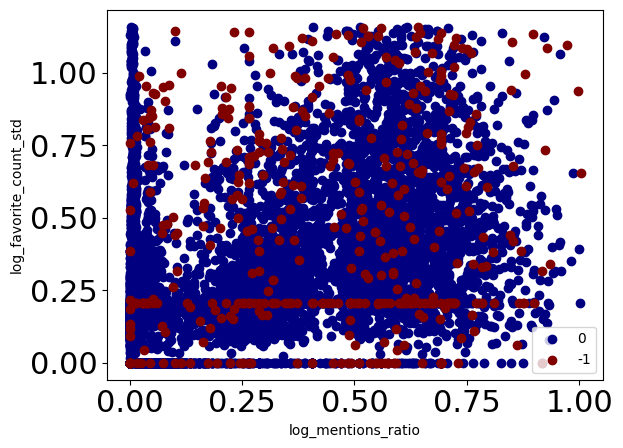

log_mentions_ratio - log_favorite_count_entropy


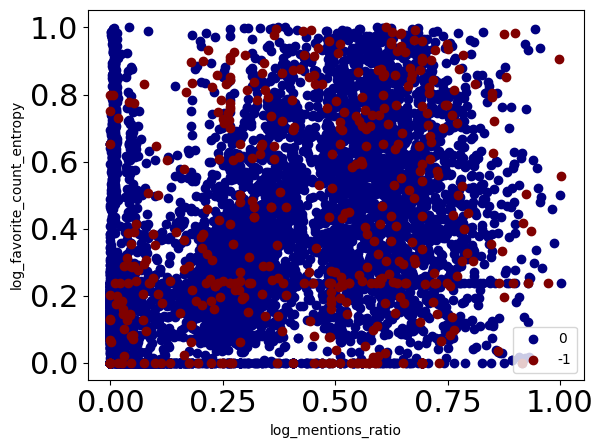

log_mentions_ratio - log_retweet_count_mean


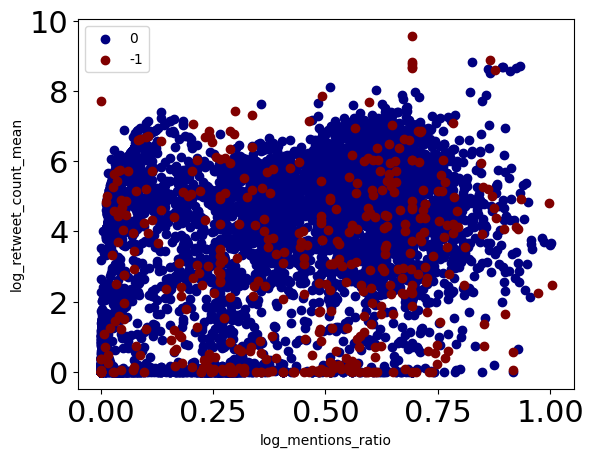

log_mentions_ratio - log_retweet_count_std


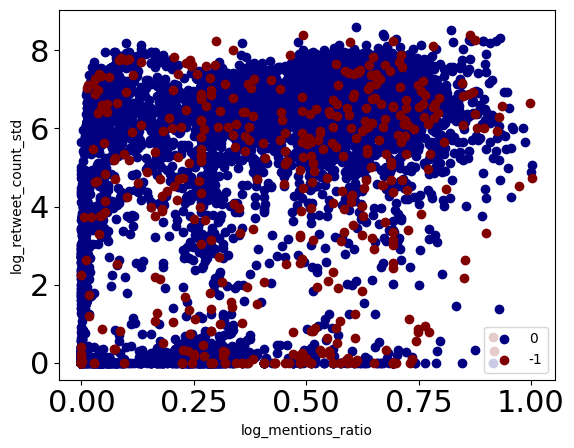

log_mentions_ratio - log_retweet_count_entropy


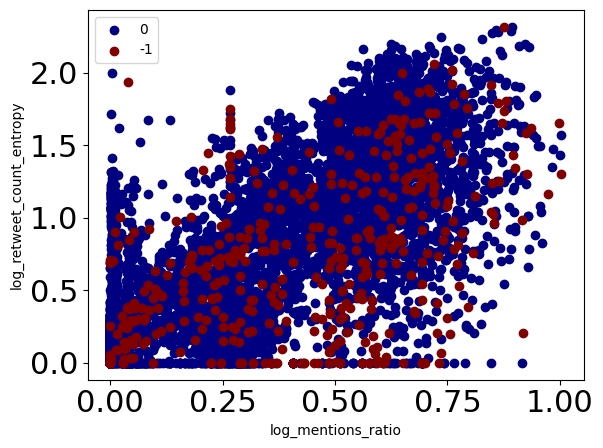

log_hashtags_ratio - log_reply_count_mean


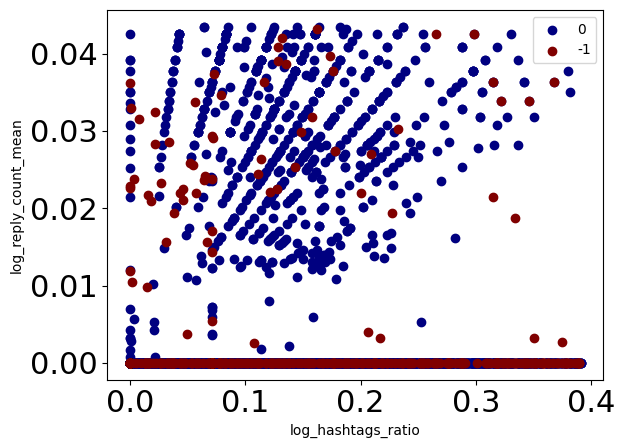

log_hashtags_ratio - log_reply_count_std


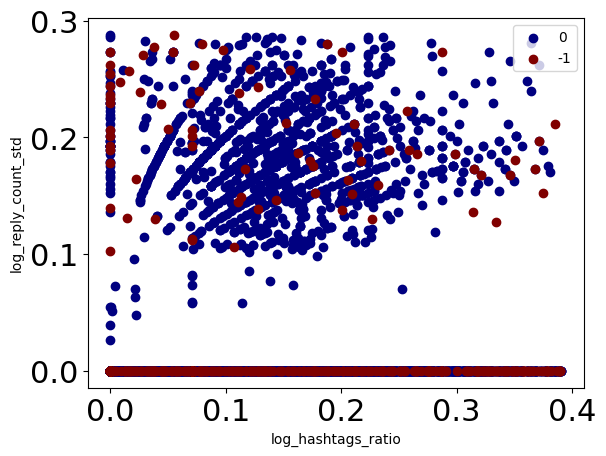

log_hashtags_ratio - log_favorite_count_mean


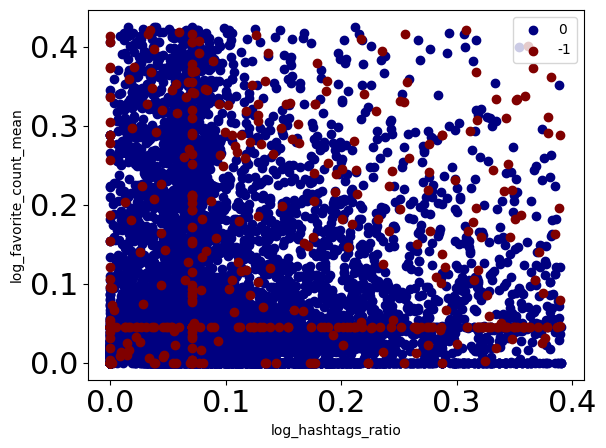

log_hashtags_ratio - log_favorite_count_std


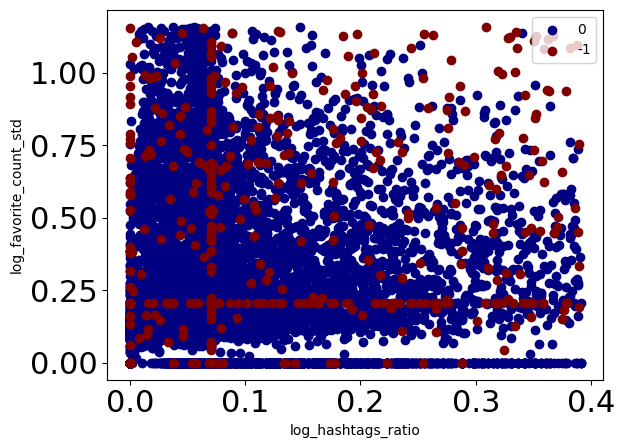

log_hashtags_ratio - log_favorite_count_entropy


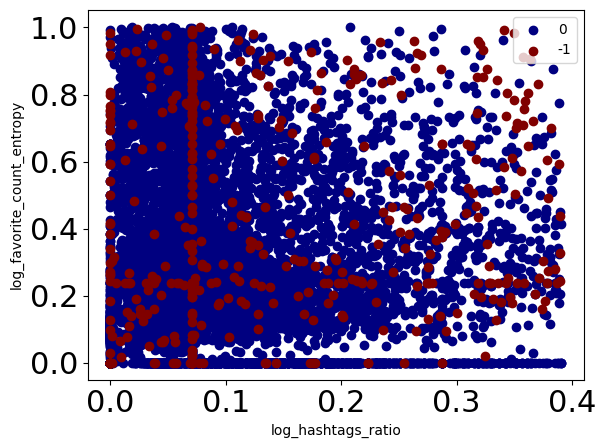

log_hashtags_ratio - log_retweet_count_mean


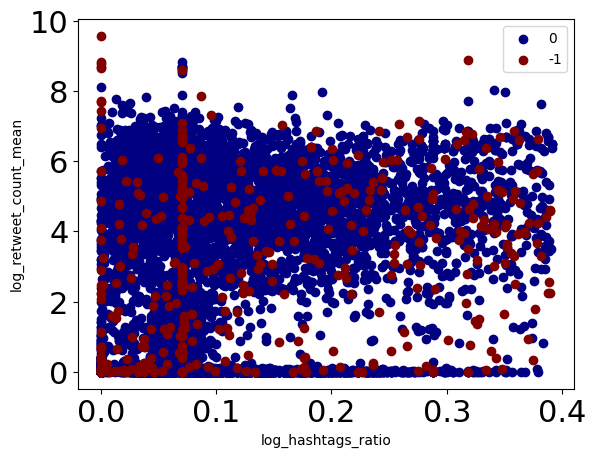

log_hashtags_ratio - log_retweet_count_std


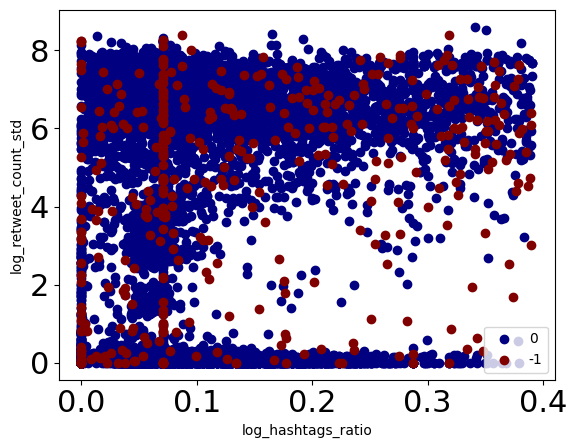

log_hashtags_ratio - log_retweet_count_entropy


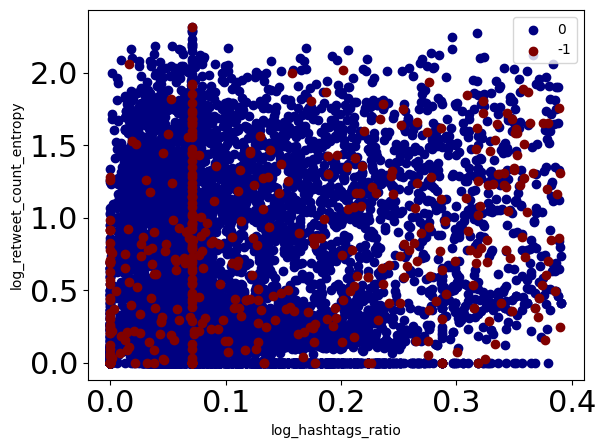

log_reply_count_mean - log_reply_count_std


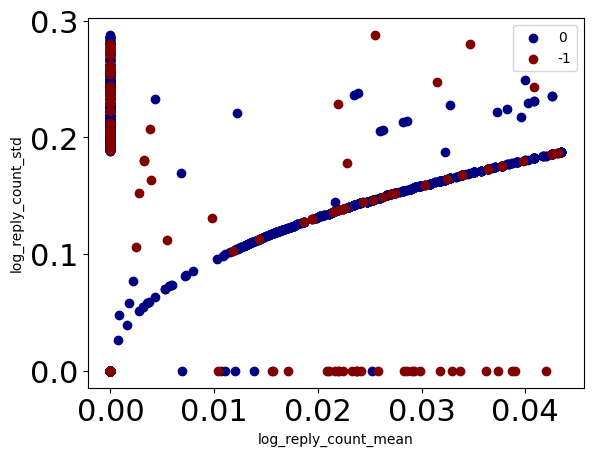

log_reply_count_mean - log_favorite_count_mean


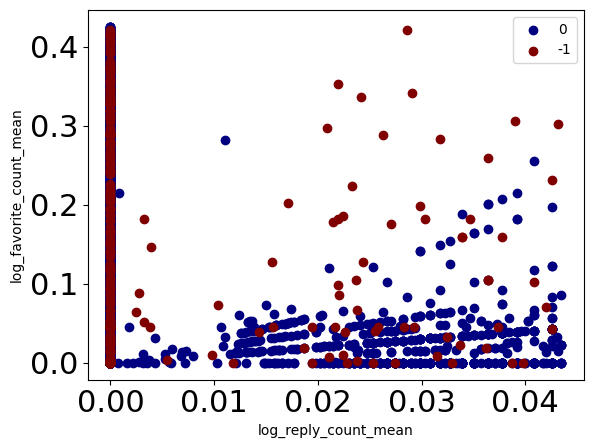

log_reply_count_mean - log_favorite_count_std


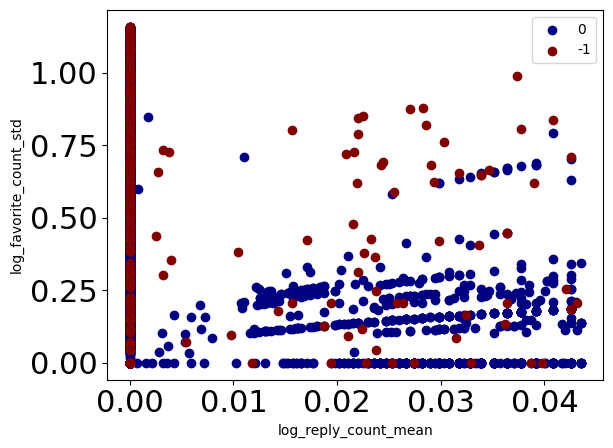

log_reply_count_mean - log_favorite_count_entropy


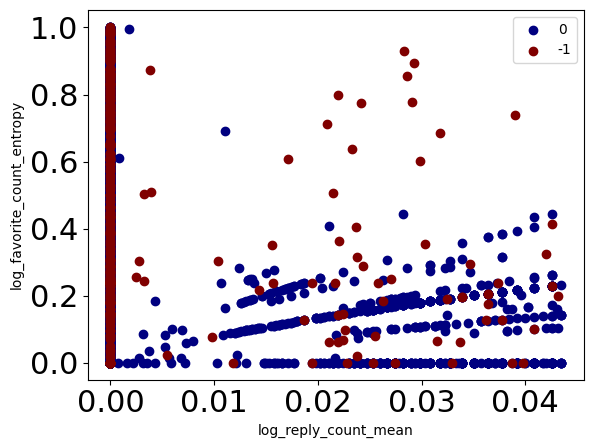

log_reply_count_mean - log_retweet_count_mean


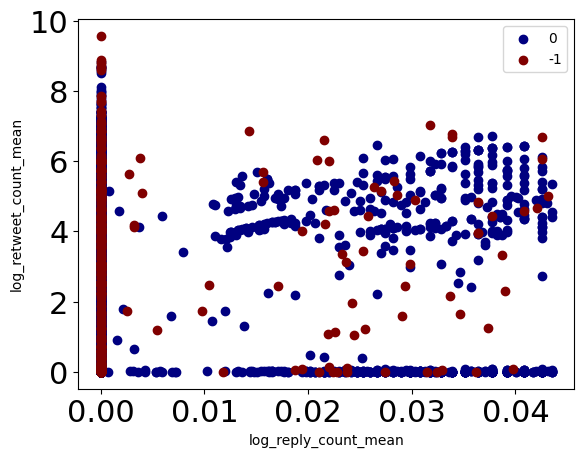

log_reply_count_mean - log_retweet_count_std


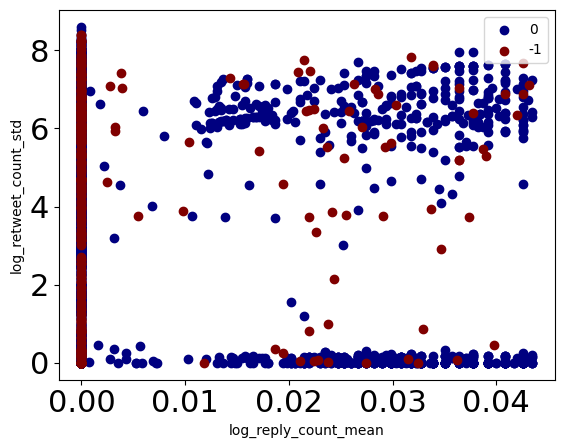

log_reply_count_mean - log_retweet_count_entropy


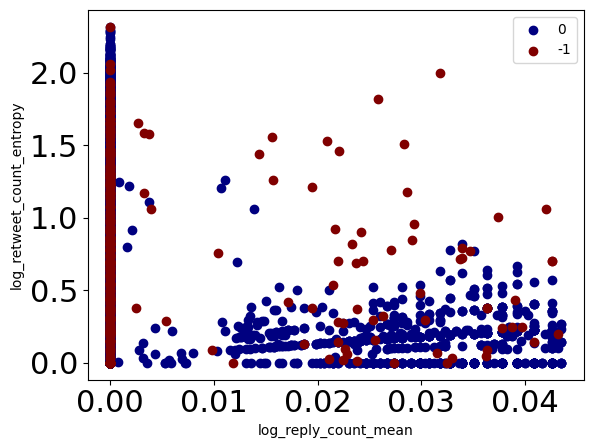

log_reply_count_std - log_favorite_count_mean


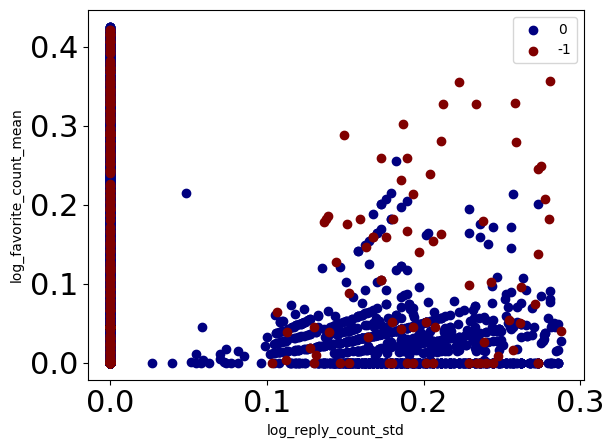

log_reply_count_std - log_favorite_count_std


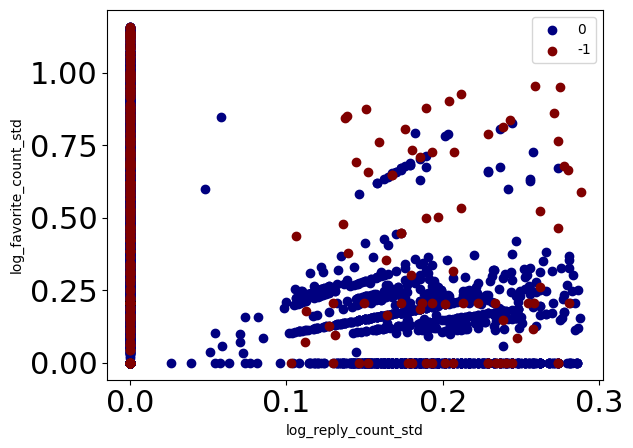

log_reply_count_std - log_favorite_count_entropy


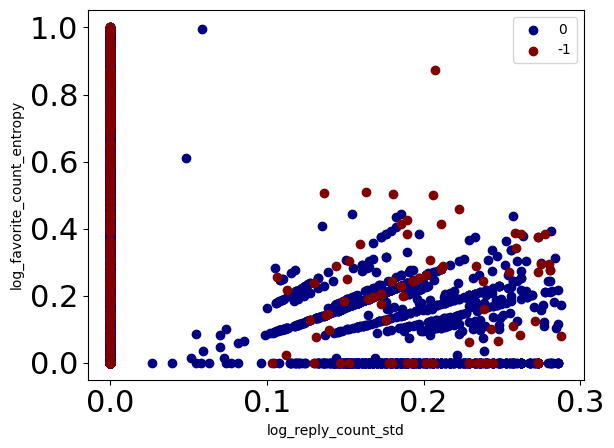

log_reply_count_std - log_retweet_count_mean


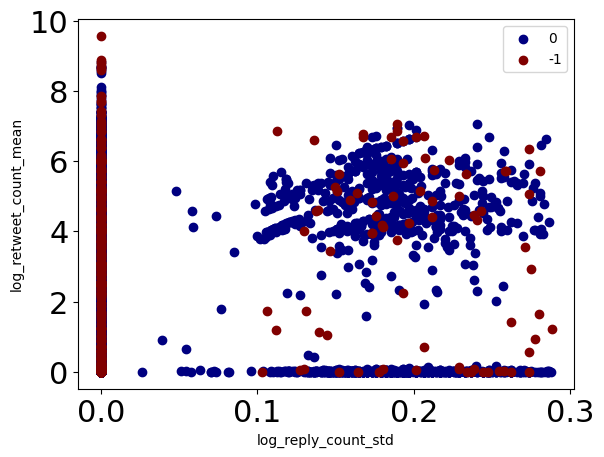

log_reply_count_std - log_retweet_count_std


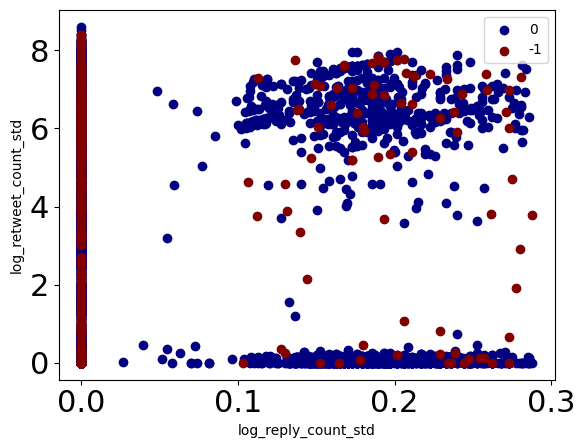

log_reply_count_std - log_retweet_count_entropy


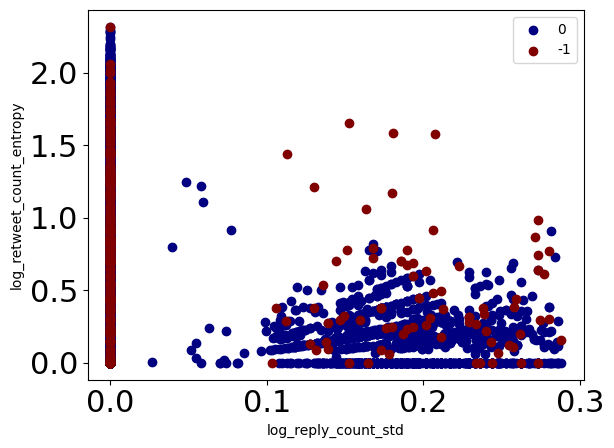

log_favorite_count_mean - log_favorite_count_std


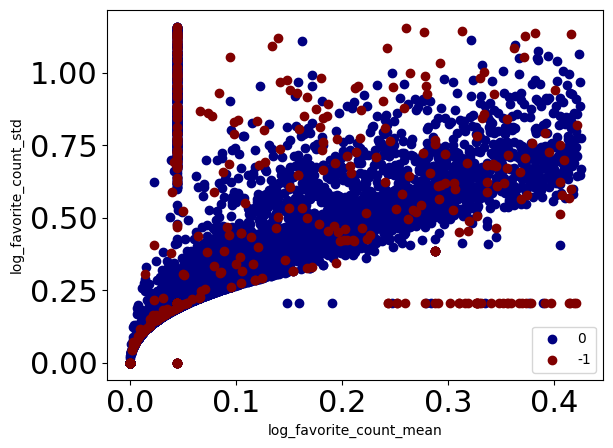

log_favorite_count_mean - log_favorite_count_entropy


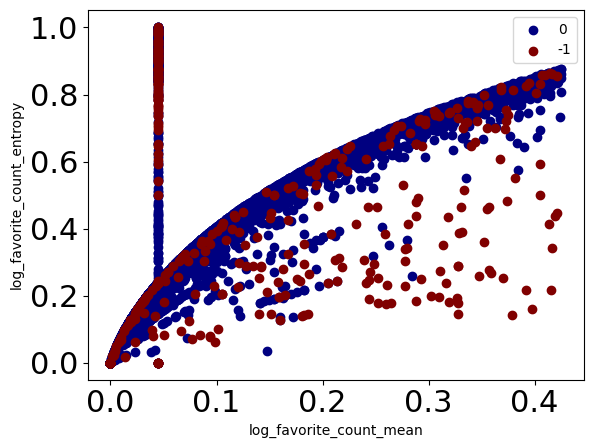

log_favorite_count_mean - log_retweet_count_mean


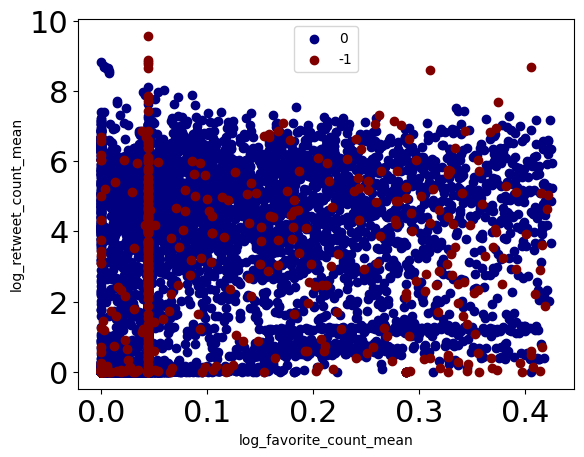

log_favorite_count_mean - log_retweet_count_std


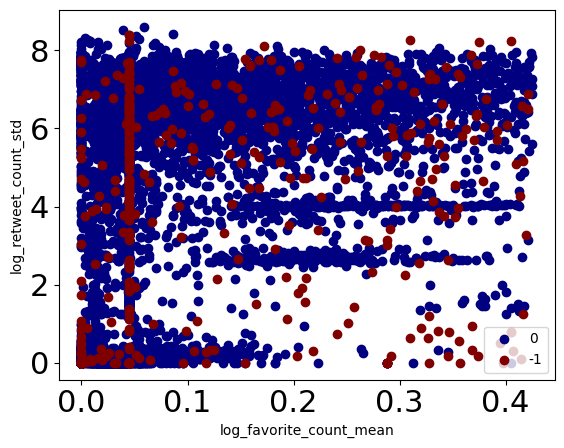

log_favorite_count_mean - log_retweet_count_entropy


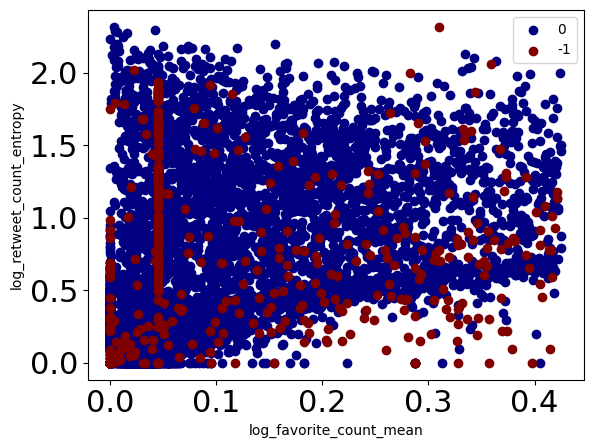

log_favorite_count_std - log_favorite_count_entropy


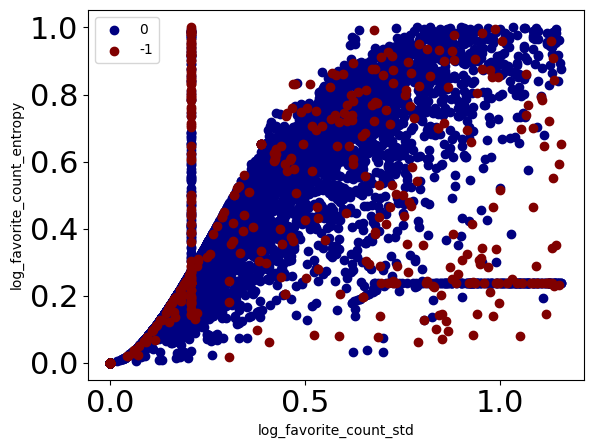

log_favorite_count_std - log_retweet_count_mean


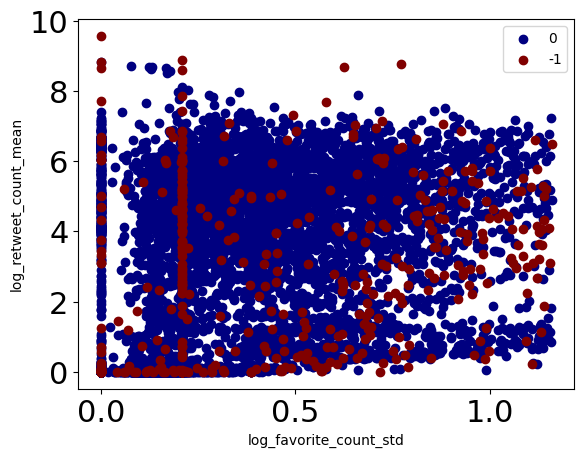

log_favorite_count_std - log_retweet_count_std


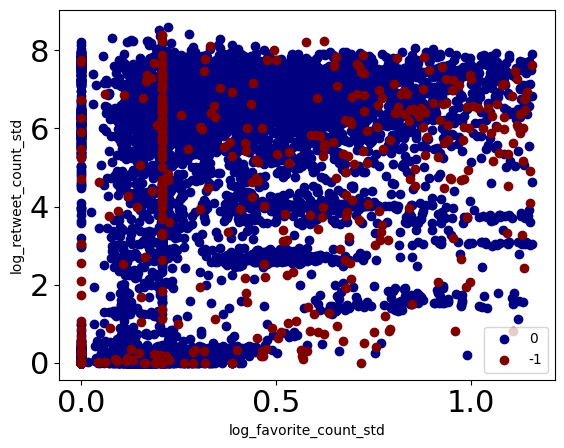

log_favorite_count_std - log_retweet_count_entropy


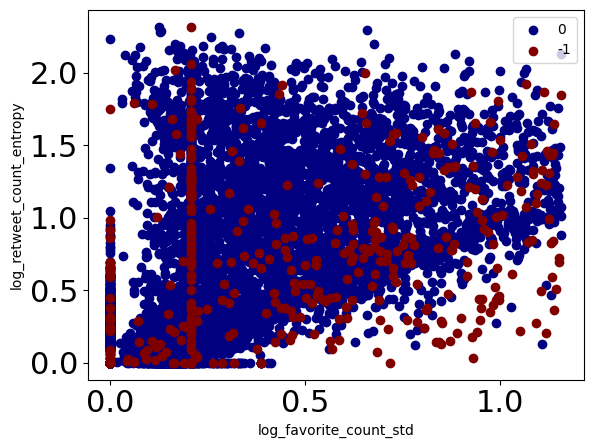

log_favorite_count_entropy - log_retweet_count_mean


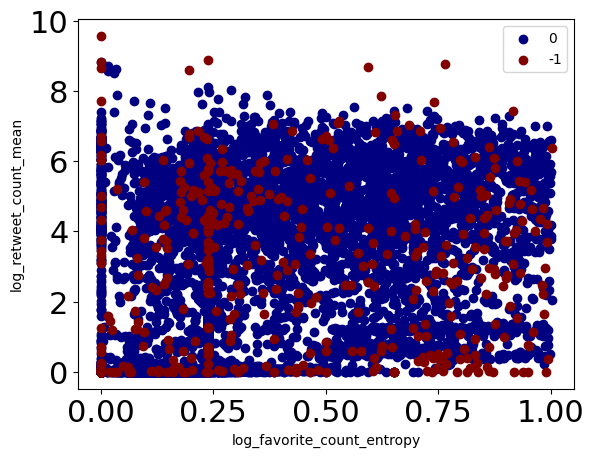

log_favorite_count_entropy - log_retweet_count_std


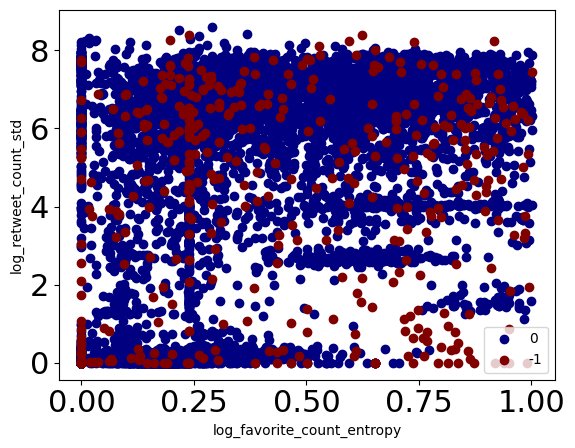

log_favorite_count_entropy - log_retweet_count_entropy


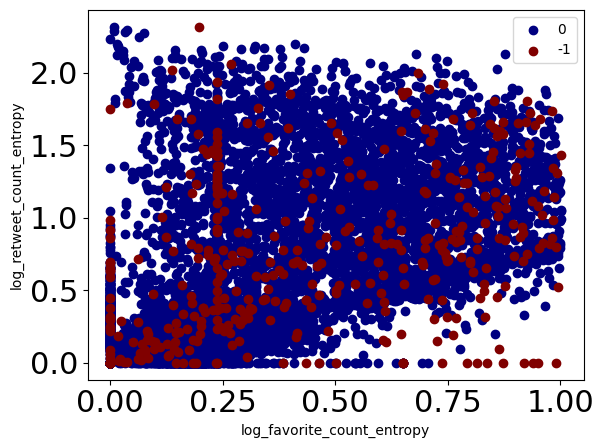

log_retweet_count_mean - log_retweet_count_std


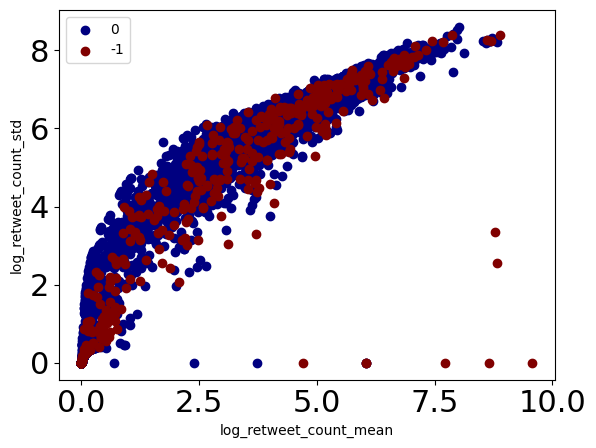

log_retweet_count_mean - log_retweet_count_entropy


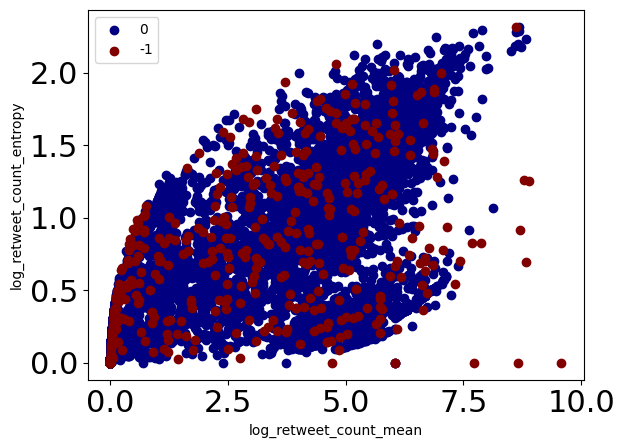

log_retweet_count_std - log_retweet_count_entropy


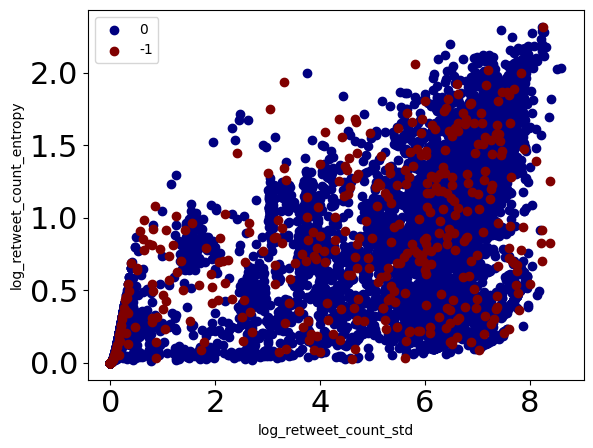

In [34]:
scatter_features_clusters(df_num_not_skewed, result.labels_)

### PCA

Apply PCA to visualize the scatter plot distribution of the clustered data

In [35]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

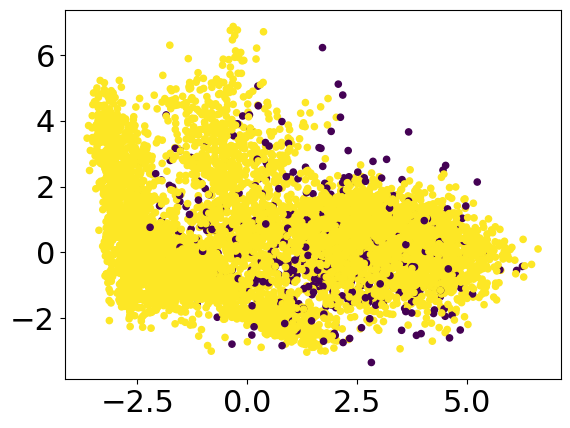

In [36]:
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=result.labels_, s=20)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.savefig("../images/clustering/DBSCAN_pca.png")
plt.show()

### Evaluation DBSCAN

Print the SSE, Silouette and Separation of the method selected out.

In [37]:
def get_sse(X, labels, centers):
    sum_ = 0
    for k in range(len(np.unique(labels))):
        datas = X[labels == np.unique(labels)[k]]
        center = centers[k]
        for data in datas:
            dist = np.linalg.norm(data - center)**2
            sum_ += dist
    return sum_

In [38]:
print('SSE %s' % get_sse(X, result.labels_, centroids))
print('Silhouette %s' % silhouette_score(X, result.labels_))
print('Separation %s' % metrics.davies_bouldin_score(X, result.labels_))

SSE 217615.79767657458
Silhouette 0.22529833311203956
Separation 3.5640733251466754
